# Imports and fixing data

# Baby Tracking Analytics

This notebook analyzes baby tracking data to identify patterns and trends in various aspects of infant care. Using data exported from a baby tracking app, we can visualize and understand:

- Feeding patterns and amounts
- Sleep schedules and duration
- Growth measurements
- Daily care activities

The analysis helps identify trends over time, correlations between different activities, and provides insights that can help optimize baby care routines.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import datetime

from helper_methods import add_day_of_week, group_and_sum_by_day, group_and_sum_durations_by_day, \
    group_and_mean_by_day_of_week, group_and_mean_sums_by_day_of_week, filter_date_range, energy_model, \
    categorize_day_night_start_only, get_type_data, get_timeperiod_data, get_plot_kwargs, \
    get_consecutive_durations_from_two_dfs, make_year_heatmap, plot_fft_results, analyze_fft, \
    plot_heatmap_with_date_range, plot_heatmap_with_date_range_transpose, NIGHT_START, MORNING_START, SLEEP_ERR, \
    BOTTLE_ERR, to_datetime, to_numeric, get_comments, TIME_PERIODS


In [3]:
pd.options.mode.copy_on_write = True

To make a new json file, do the following in this directory:
```
node convert_to_json.mjs PATH_TO_REALM.realm ./export.json
```

In [4]:
import json

# Open and read the JSON file
with open(("export.json"), 'r') as file:
# with open(("28-02-2025 07_49_03 mybaby-default.json"), 'r') as file:
    data = json.load(file)

full_df = pd.DataFrame.from_dict(data["EventItem"])
# full_df = full_df.set_index('id')

custom_start_date = '2024-10-01'
custom_end_date = '2025-06-29'

In [5]:
full_df.columns

Index(['id', 'babyId', 'comment', 'photo', 'type', 'enteredDate',
       'customComment', 'leftStart', 'leftEnd', 'rightStart', 'rightEnd',
       'leftSeconds', 'rightSeconds', 'mixType', 'bottleAmount',
       'bottleAmountOunce', 'weight', 'height', 'headCirc', 'temperature',
       'weightPounds', 'heightInches', 'headCircInches', 'temperatureFah',
       'breast', 'singleTimerStart', 'singleTimerSeconds',
       'doubleLeftTimerStart', 'doubleRightTimerStart',
       'doubleLeftTimerSeconds', 'doubleRightTimerSeconds'],
      dtype='object')

In [6]:
pd.unique(full_df.loc[:,"type"])

array(['lactation', 'bottle', 'pumping', 'taking_med', 'diaper',
       'temperature', 'vaccination', 'weight', 'height', 'head_circ',
       'bathing', 'sleep', 'custom_achieve', 'stroll', 'lure'],
      dtype=object)

## single instance

In [7]:
full_df.iloc[-1]

id                         702FFD25-F526-4CB2-8599-E844F3234A78
babyId                     50269EA9-7196-43CC-AAC7-996E4154C610
comment                                                        
photo                                                      None
type                                                     bottle
enteredDate                            2025-07-11T11:05:56.000Z
customComment                                                  
leftStart                                                  None
leftEnd                                                    None
rightStart                                                 None
rightEnd                                                   None
leftSeconds                                                   0
rightSeconds                                                  0
mixType                                                 mixture
bottleAmount                                                180
bottleAmountOunce                       

## Fix date and numeric fields

In [8]:
full_df = to_datetime(full_df)
full_df = to_numeric(full_df)


In [9]:
full_df.groupby('type').count()

,id,babyId,comment,photo,enteredDate,customComment,leftStart,leftEnd,rightStart,rightEnd,...,heightInches,headCircInches,temperatureFah,breast,singleTimerStart,singleTimerSeconds,doubleLeftTimerStart,doubleRightTimerStart,doubleLeftTimerSeconds,doubleRightTimerSeconds
type,,,,,,,,,,,,,,,,,,,,,
bathing,59,59,59,0,59,59,59,59,0,0,...,0,0,0,59,0,25,0,0,0,0
bottle,1958,1958,1958,0,1958,1958,0,0,0,0,...,0,0,0,1958,0,0,0,0,0,0
custom_achieve,1,1,1,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
diaper,356,356,356,0,356,356,0,0,0,0,...,0,0,0,356,0,0,0,0,0,0
head_circ,8,8,8,0,8,8,0,0,0,0,...,0,8,0,8,0,0,0,0,0,0
height,9,9,9,0,9,9,0,0,0,0,...,9,0,0,9,0,0,0,0,0,0
lactation,156,156,156,0,156,156,156,156,0,0,...,0,0,0,156,0,0,0,0,5,4
lure,305,305,305,0,305,305,0,0,0,0,...,0,0,0,305,0,0,0,0,0,0
pumping,328,328,328,0,328,328,0,0,0,0,...,0,0,0,328,0,0,0,0,0,0


In [10]:
non_empty_strings = get_comments(full_df)

In [11]:
non_empty_strings

,id,babyId,comment,photo,type,enteredDate,customComment,leftStart,leftEnd,rightStart,...,heightInches,headCircInches,temperatureFah,breast,singleTimerStart,singleTimerSeconds,doubleLeftTimerStart,doubleRightTimerStart,doubleLeftTimerSeconds,doubleRightTimerSeconds
151,47907606-DEBC-415F-BBF5-29D8566623EA,50269EA9-7196-43CC-AAC7-996E4154C610,Gas\n,None,taking_med,2024-10-19 09:10:42-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
156,28405EC5-90DE-4F45-9EF4-09034D82F768,50269EA9-7196-43CC-AAC7-996E4154C610,Gas,None,taking_med,2024-10-19 22:30:24-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
173,7D411CE4-2E1D-492A-90A1-10BA2F0B2D78,50269EA9-7196-43CC-AAC7-996E4154C610,Gas,None,taking_med,2024-10-20 20:00:44-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
177,9AC2FF0A-F711-4DD3-ABFE-E6E812BBAA7E,50269EA9-7196-43CC-AAC7-996E4154C610,Gas,None,taking_med,2024-10-20 22:30:42-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
196,15711C94-D55C-4541-A27C-7F62FBBA0D0E,50269EA9-7196-43CC-AAC7-996E4154C610,Gas,None,taking_med,2024-10-21 22:30:12-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4761,32FE8FF3-FF4B-4990-8630-4E0C495FC85A,50269EA9-7196-43CC-AAC7-996E4154C610,,None,lure,2025-07-10 08:15:59-04:00,Banana oat,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
4767,583D2BE9-4310-4EF2-907A-DD94712CAB3A,50269EA9-7196-43CC-AAC7-996E4154C610,,None,lure,2025-07-11 17:00:31-04:00,Drumstick rigatoni acorn squash,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
4770,E2E917B7-996C-43F5-A3C6-A4DD1DA481C7,50269EA9-7196-43CC-AAC7-996E4154C610,,None,lure,2025-07-11 13:45:28-04:00,Puree oats,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
4771,54C3F82E-A585-4E28-84A6-99872C674E45,50269EA9-7196-43CC-AAC7-996E4154C610,,None,diaper,2025-07-11 13:30:43-04:00,dirty,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN


# Plots

## Feeding

This section analyzes bottle feeding patterns including total daily intake, day vs. night feeding differences, and feeding schedules.

The visualizations help identify:
- How feeding amounts change over time as the baby grows
- Whether there are preferred feeding times or days
- Patterns in feeding frequency and volume
- How day and night feeding behaviors differ


### Daily feeding over time

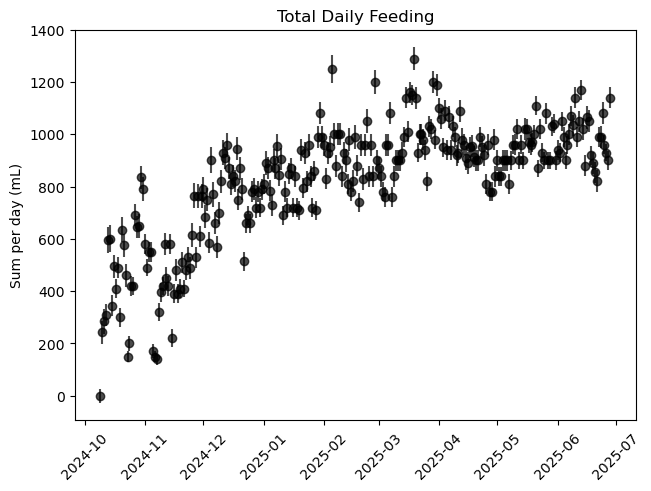

In [12]:
# Group and sum by day
filtered_df = filter_date_range(full_df, 'enteredDate', custom_start_date, custom_end_date)
df = categorize_day_night_start_only(get_type_data(filtered_df, 'bottle'), 'enteredDate')
daily_totals = group_and_sum_by_day(df, 'enteredDate', ['bottleAmount'], error_value=BOTTLE_ERR)

# Add day of week
daily_totals_with_day = add_day_of_week(daily_totals, 'enteredDate')
plt.errorbar(daily_totals.loc[:,'enteredDate'], 
             daily_totals.loc[:,'bottleAmount_sum'],
             yerr=daily_totals.loc[:,'bottleAmount_err'],
             **get_plot_kwargs('all'))
plt.xticks(rotation=45)
plt.title("Total Daily Feeding")
plt.ylabel("Sum per day (mL)")
plt.savefig("figures/total_daily_feeding.png")

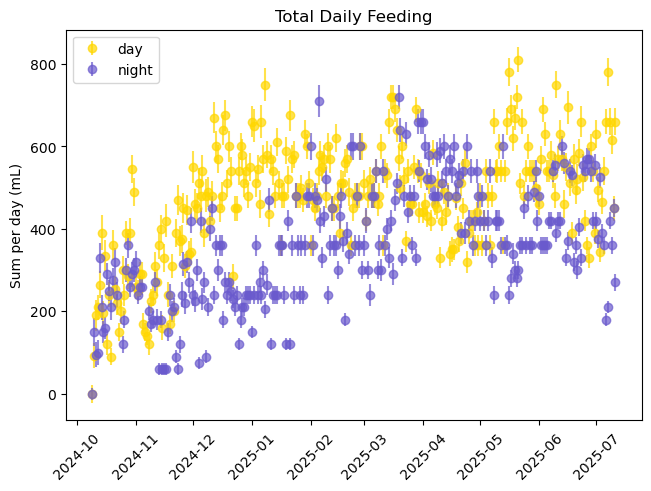

In [13]:
# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df, 'bottle'), 'enteredDate')
daily_totals = group_and_sum_by_day(df, 'enteredDate', ['bottleAmount'], error_value=BOTTLE_ERR)

# # Add day of week
# daily_totals_with_day = add_day_of_week(daily_totals, 'enteredDate')
# plt.errorbar(daily_totals.loc[:,'enteredDate'], 
#              daily_totals.loc[:,'bottleAmount_sum'], 
#              yerr=daily_totals.loc[:,'bottleAmount_err'], 
#              **get_plot_kwargs('all') )

for period in ['day','night']:
    daily_totals = group_and_sum_by_day(get_timeperiod_data(df, period), 'enteredDate', ['bottleAmount'], error_value=BOTTLE_ERR)

    # Add day of week
    daily_totals_with_day = add_day_of_week(daily_totals, 'enteredDate')
    plt.errorbar(daily_totals['enteredDate'],
                 daily_totals['bottleAmount_sum'],
                 yerr=daily_totals['bottleAmount_err'],
                 **get_plot_kwargs(period))
plt.legend()
plt.xticks(rotation=45)
plt.title("Total Daily Feeding")
plt.ylabel("Sum per day (mL)")
plt.savefig("figures/total_daily_feeding_day_night.png")

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_64314/995236790.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(energy_model, time, calories, p0=p0)


(array([19997.16666667, 20028.16666667, 20058.20833333, 20089.20833333,
        20120.20833333, 20148.20833333, 20179.16666667, 20209.16666667,
        20240.16666667, 20270.16666667]),
 [Text(19997.166666666668, 0, '2024-10'),
  Text(20028.166666666668, 0, '2024-11'),
  Text(20058.208333333332, 0, '2024-12'),
  Text(20089.208333333332, 0, '2025-01'),
  Text(20120.208333333332, 0, '2025-02'),
  Text(20148.208333333332, 0, '2025-03'),
  Text(20179.166666666668, 0, '2025-04'),
  Text(20209.166666666668, 0, '2025-05'),
  Text(20240.166666666668, 0, '2025-06'),
  Text(20270.166666666668, 0, '2025-07')])

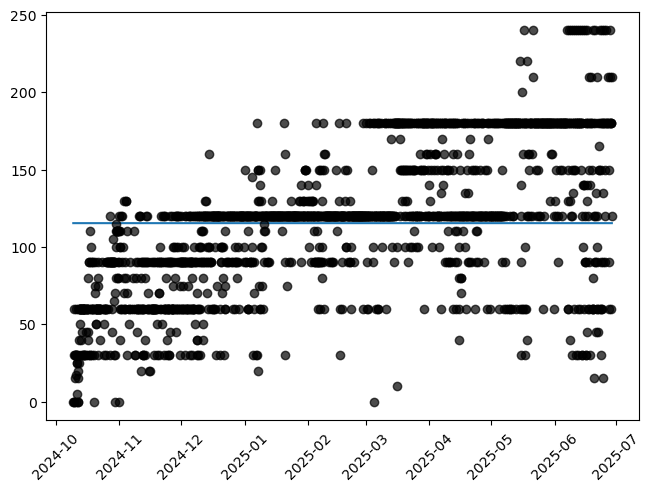

In [14]:
filtered_df = filter_date_range(full_df, 'enteredDate', custom_start_date, custom_end_date)
df = get_type_data(filtered_df, 'bottle')
# plt.plot(df['enteredDate'], df['bottleAmount'],'o')

# Your data
# Assuming 'df' is your pandas DataFrame and 'your_datetime_column' is the column name
datetime_array = df.loc[:,'enteredDate'].to_numpy()
earliest_datetime = datetime_array.min()

time = [(d-earliest_datetime).total_seconds() for d in datetime_array]
calories = df.loc[:,'bottleAmount'].to_numpy()  # Calorie intake

# Initial parameter guesses
p0 = [min(calories), max(calories) - min(calories), 0.1, time[0]]

# Fit the model
popt, _ = curve_fit(energy_model, time, calories, p0=p0)

# popt now contains the optimized parameters [E0, A, k, t0]

plt.plot(datetime_array, energy_model(time, *popt))
plt.plot(datetime_array, calories, **get_plot_kwargs('all'))

plt.xticks(rotation=45)

### Feeding Frequency

In [15]:
time_bins, time_counts, freq, power_spectrum, peak_frequencies = analyze_fft(df, 'enteredDate', 'bottleAmount')

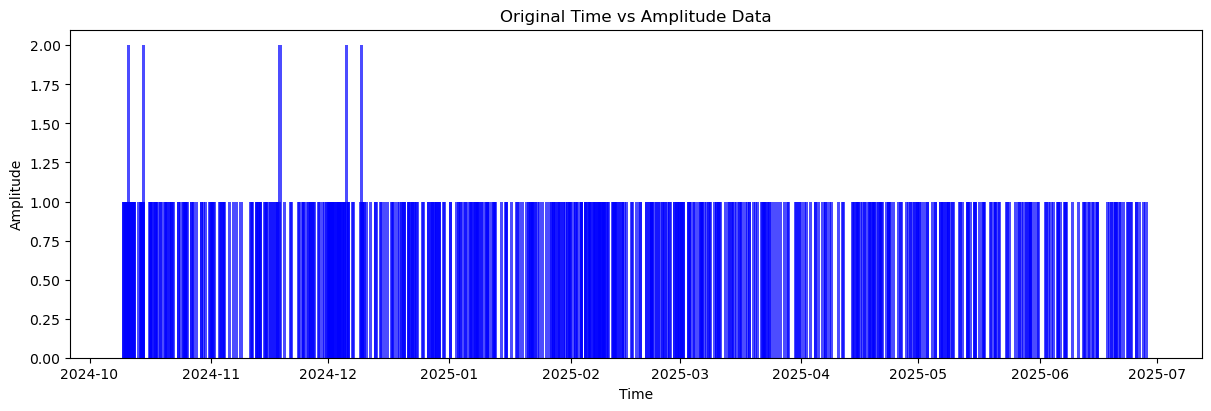

/Users/deividribeiro/Documents/Work/Projects/Baby/realm/helper_methods.py:582: RuntimeWarning: divide by zero encountered in divide
  period = (1 / freq)


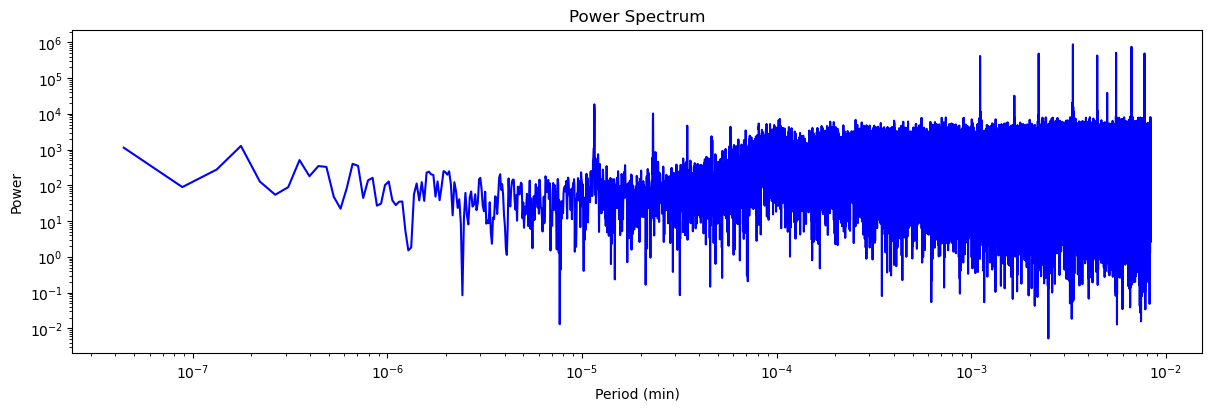

In [16]:
(fig1, ax1), (fig2, ax2) = plot_fft_results(time_bins[::20], time_counts[::20], freq, power_spectrum)

In [17]:
# Report the top 5 peak frequencies
top_5_peak_frequencies = peak_frequencies[np.argsort(power_spectrum[np.isin(freq, peak_frequencies)])][-5:]
print(f"Top 5 peak frequencies are: {(1/top_5_peak_frequencies[::-1])/60}")

Top 5 peak frequencies are: [5.00001324 2.50000662 3.         2.14285471 7.49997021]


ADF Test on Original Series:
ADF Statistic: -2.533609411380002
p-value: 0.10750944497555365

ADF Test on Weekly Difference:
ADF Statistic: -5.623186146853668
p-value: 1.1328092890049224e-06

ADF Test on Monthly Difference:
ADF Statistic: -3.501353856718363
p-value: 0.007952392153626083


/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_64314/2145758422.py:52: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


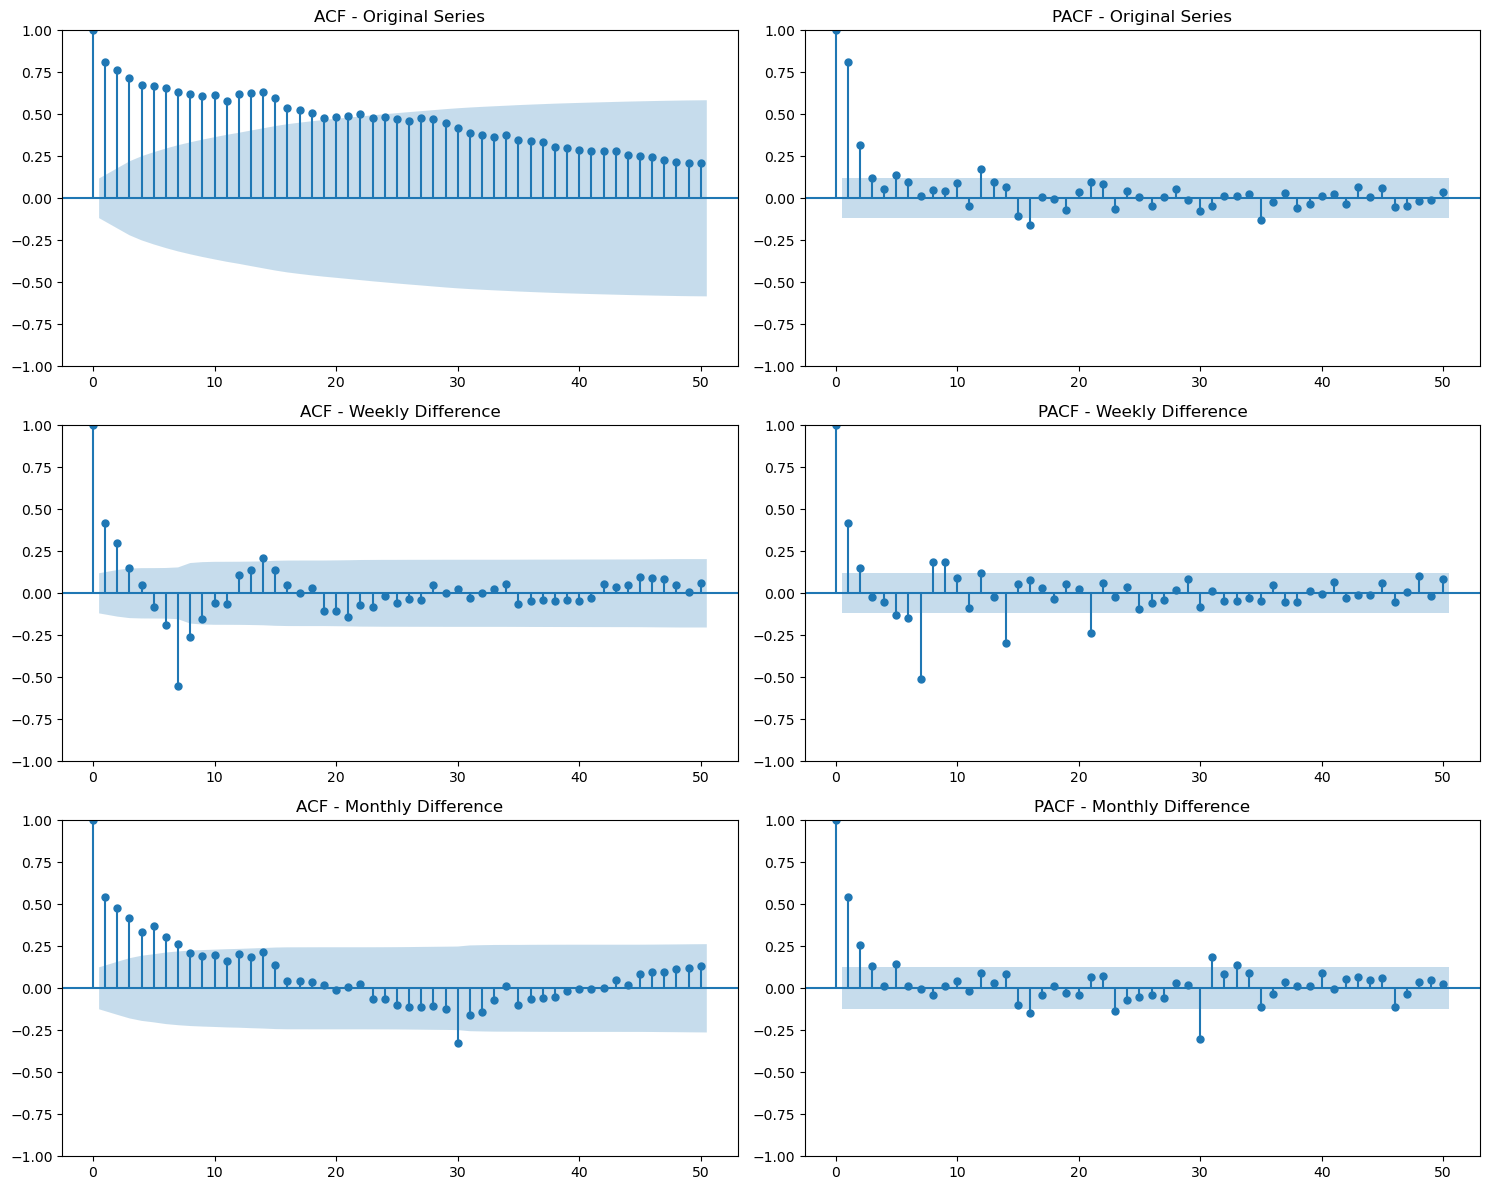

In [94]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Prepare the time series data from daily feeding totals
df = get_type_data(full_df, 'bottle')
daily_totals = group_and_sum_by_day(df, 'enteredDate', ['bottleAmount'], error_value=BOTTLE_ERR)
feeding_ts = daily_totals['bottleAmount_sum']
# feeding_ts = np.log(daily_totals['bottleAmount_sum'])
# feeding_ts[feeding_ts == -np.inf] = 0

# Perform ADF test on original series
print("ADF Test on Original Series:")
result = adfuller(feeding_ts)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Create first difference weekly
feeding_ts_diff_week = feeding_ts.diff(7).dropna()
print("\nADF Test on Weekly Difference:")
result = adfuller(feeding_ts_diff_week)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Create first difference monthly
feeding_ts_diff_month = feeding_ts.diff(30).dropna()
print("\nADF Test on Monthly Difference:")
result = adfuller(feeding_ts_diff_month)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Plot ACF/PACF for original series
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 12))

# Original series
plot_acf(feeding_ts, lags=50, ax=ax1)
ax1.set_title('ACF - Original Series')
plot_pacf(feeding_ts, lags=50, ax=ax2)
ax2.set_title('PACF - Original Series')

# Weekly difference
plot_acf(feeding_ts_diff_week, lags=50, ax=ax3)
ax3.set_title('ACF - Weekly Difference')
plot_pacf(feeding_ts_diff_week, lags=50, ax=ax4)
ax4.set_title('PACF - Weekly Difference')

# Monthly difference
plot_acf(feeding_ts_diff_month, lags=50, ax=ax5)
ax5.set_title('ACF - Monthly Difference')
plot_pacf(feeding_ts_diff_month, lags=50, ax=ax6)
ax6.set_title('PACF - Monthly Difference')

plt.tight_layout()
plt.savefig("figures/feeding_acf_pacf_differences.png")
plt.show()


#### SARIMA Model Analysis

Test these SARIMA models with different parameters and compare their AIC/BIC scores to find the best fit

In [99]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Test different SARIMA models with weekly and monthly seasonality
models = [
    # Weekly seasonality
    ((2, 1, 0), (1, 1, 0, 7)),
    ((2, 1, 1), (1, 1, 0, 7)),
    ((2, 1, 0), (1, 1, 1, 7)),
    # Monthly seasonality 
    ((2, 1, 0), (1, 1, 0, 30)),
    ((2, 1, 1), (1, 1, 0, 30)),
    ((2, 1, 0), (1, 1, 1, 30)),
    ((2, 1, 0), (2, 1, 1, 30))
]

results = []
for order, seasonal_order in models:
    model = SARIMAX(feeding_ts,
                    order=order,
                    seasonal_order=seasonal_order)
    results.append(model.fit(disp=False))

/usr/local/anaconda3/envs/jupyter/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [100]:
# Compare AIC and BIC scores
scores = pd.DataFrame({
    'Model': ['SARIMA(2,1,0)(1,1,0)[7]',
              'SARIMA(2,1,1)(1,1,0)[7]',
              'SARIMA(2,1,0)(1,1,1)[7]',
              'SARIMA(2,1,0)(1,1,0)[30]',
              'SARIMA(2,1,1)(1,1,0)[30]',
              'SARIMA(2,1,0)(1,1,1)[30]',
              'SARIMA(2,1,0)(2,1,1)[30]',],
    'AIC': [result.aic for result in results],
    'BIC': [result.bic for result in results]
})

print("Model Comparison:")
print(scores)

# Get best model based on AIC
best_model_idx = scores['AIC'].idxmin()
best_model = results[best_model_idx]
print(f"\nBest model based on AIC: {scores.iloc[best_model_idx]['Model']}")
best_model.summary()

Model Comparison:
                      Model          AIC          BIC
0   SARIMA(2,1,0)(1,1,0)[7]  3385.625773  3399.989721
1   SARIMA(2,1,1)(1,1,0)[7]  3365.766840  3383.721775
2   SARIMA(2,1,0)(1,1,1)[7]  3337.139711  3355.094646
3  SARIMA(2,1,0)(1,1,0)[30]  3117.991090  3131.996123
4  SARIMA(2,1,1)(1,1,0)[30]  3102.126682  3119.632973
5  SARIMA(2,1,0)(1,1,1)[30]  3097.296330  3114.802621
6  SARIMA(2,1,0)(2,1,1)[30]  3096.787422  3117.794971

Best model based on AIC: SARIMA(2,1,0)(2,1,1)[30]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     bottleAmount_sum   No. Observations:                  276
Model:             SARIMAX(2, 1, 0)x(2, 1, [1], 30)   Log Likelihood               -1542.394
Date:                              Tue, 15 Jul 2025   AIC                           3096.787
Time:                                      17:36:26   BIC                           3117.795
Sample:                                           0   HQIC                          3105.247
                                              - 276                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5050      0.062     -8.174      0.000      -0.626      -0.384
ar.L2         -0.2186      0.066     -3.288      0.001      -0.349      -0.088
ar.S.L30       0.0985      0.144      0.686      0.493      -0.183       0.380
ar.S.L60       0.1352      0.112      1.205      0.228      -0.085       0.355
ma.S.L30      -0.9992     37.207     -0.027      0.979     -73.924      71.925
sigma2      1.383e+04   5.13e+05      0.027      0.978   -9.92e+05    1.02e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 8.18
Prob(Q):                              0.78   Prob(JB):                         0.02
Heteroskedasticity (H):               0.41   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [97]:
# Non-seasonal AR terms
phi1 = best_model.params.get('ar.L1')
phi2 = best_model.params.get('ar.L2')

print(f"AR coefficients: φ1 = {phi1}, φ2 = {phi2}")

coeffs = [1, -phi1, -phi2]
roots = np.roots(coeffs)
print("Roots:", roots)
print("Magnitudes:", np.abs(roots))
if all(np.abs(roots) > 1):
    print("The process is stationary.")
else:
    print("The process is not stationary.")



AR coefficients: φ1 = -0.505013563206152, φ2 = -0.2185790219177691
Roots: [-0.25250678+0.3934709j -0.25250678-0.3934709j]
Magnitudes: [0.46752435 0.46752435]
The process is not stationary.


In [101]:
phi_s = best_model.params.get('ar.S.L30')
# Seasonal AR(1): 1 - φ_s z^s
seasonal_coeffs = [1, -phi_s]
seasonal_root = np.roots(seasonal_coeffs)
print(seasonal_root)

[0.09849276]


/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_64314/1465997172.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


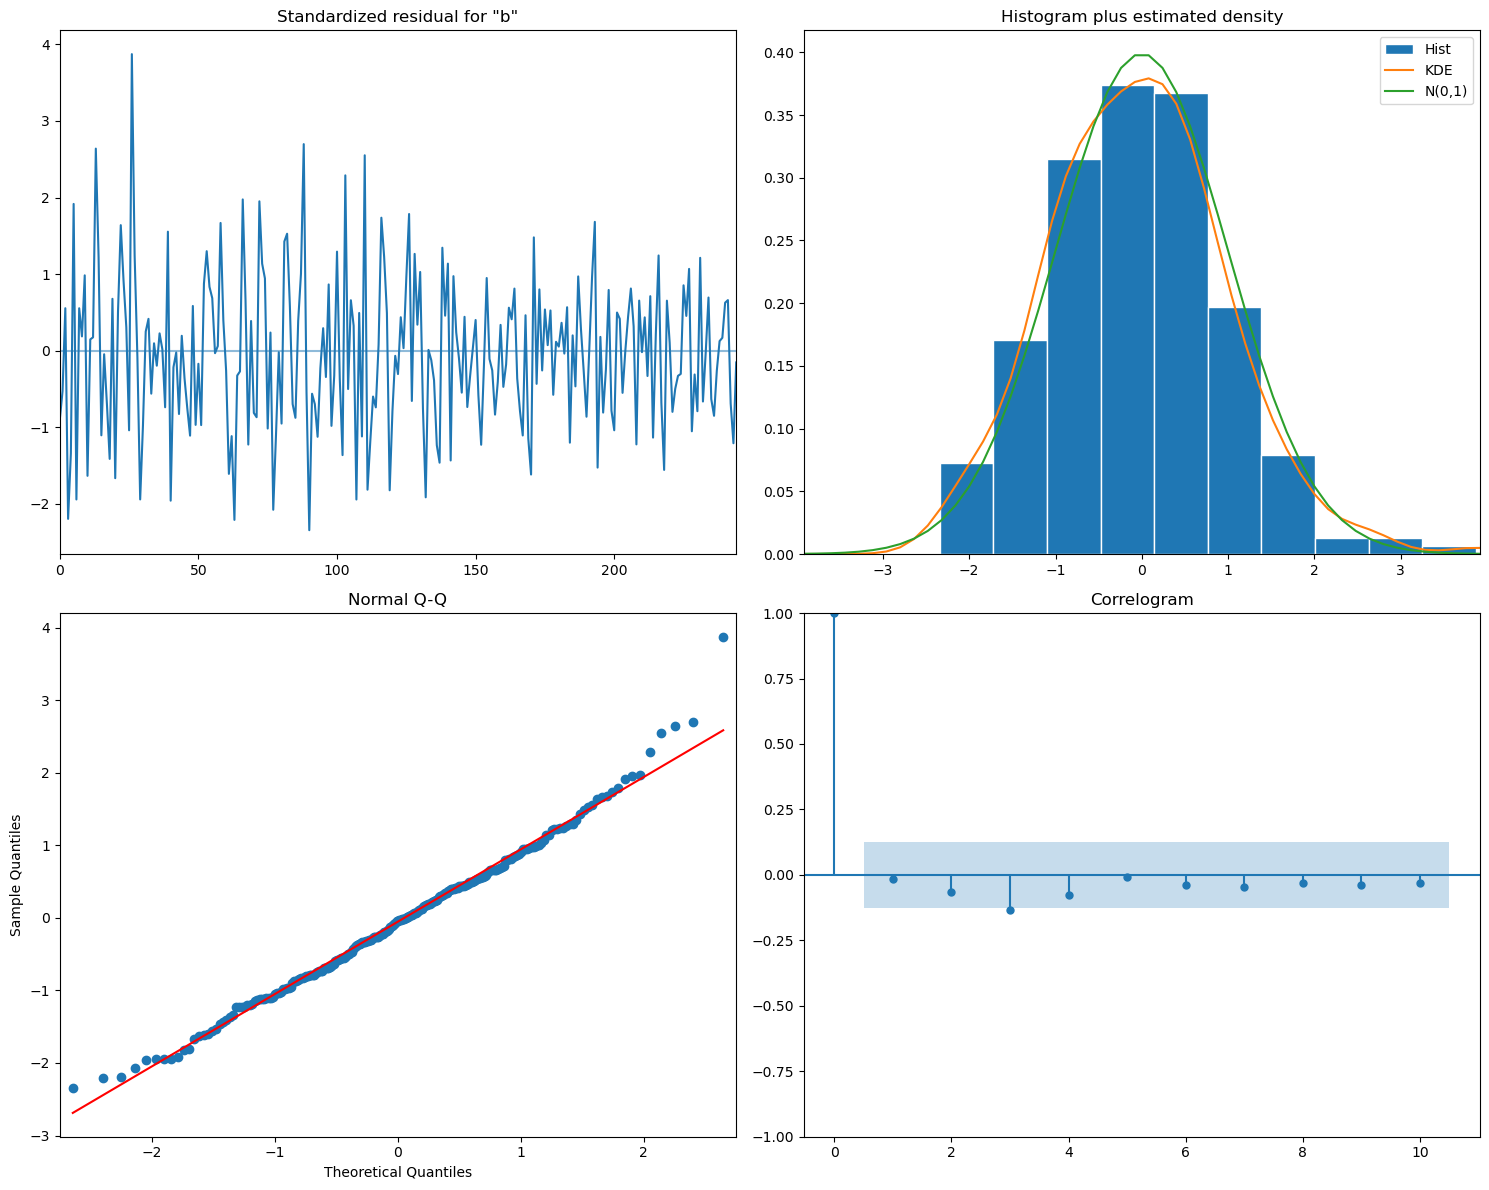

In [102]:
# Plot diagnostics for best model
best_model.plot_diagnostics(figsize=(15, 12))
plt.tight_layout()
plt.savefig("figures/sarima_diagnostics.png")

In [103]:
from arch import arch_model

# Get residuals from SARIMA model
resid = best_model.resid

# Fit GARCH(1,1) model to residuals
garch_model = arch_model(resid, vol='GARCH', p=1, q=1)
garch_results = garch_model.fit(disp="off")

print(garch_results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1739.86
Distribution:                  Normal   AIC:                           3487.73
Method:            Maximum Likelihood   BIC:                           3502.21
                                        No. Observations:                  276
Date:                Tue, Jul 15 2025   Df Residuals:                      275
Time:                        17:36:54   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -5.7513      7.280     -0.790      0.430 [-20.021,  8.51

/usr/local/anaconda3/envs/jupyter/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.976e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


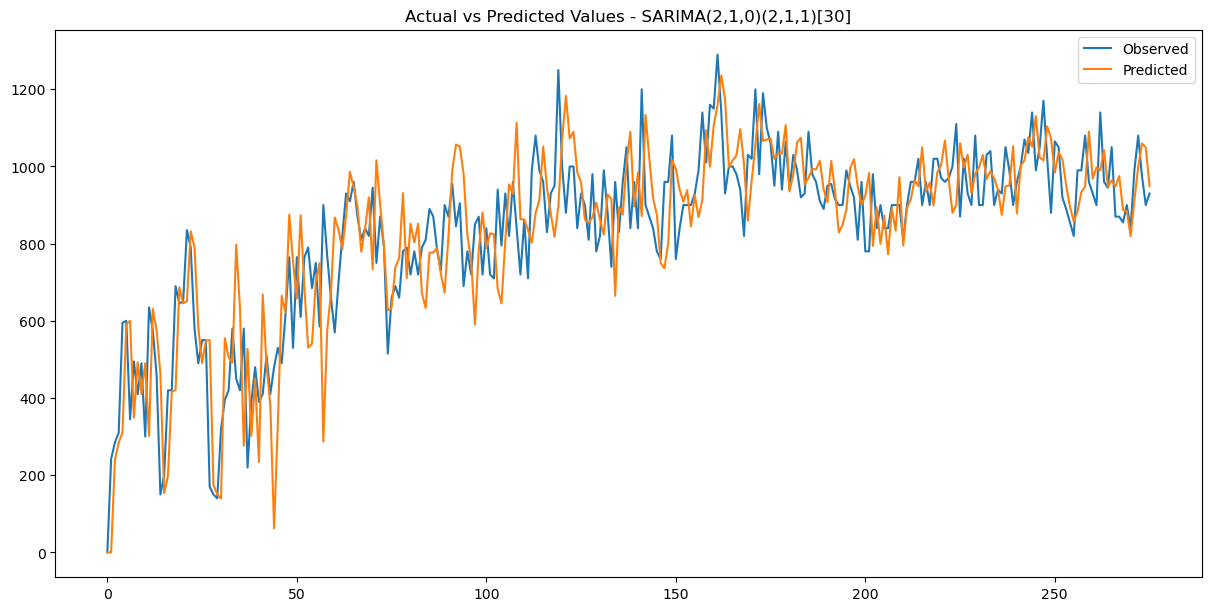

In [104]:
# Plot actual vs predicted values
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(feeding_ts, label='Observed')
best_model.fittedvalues.plot(ax=ax, label='Predicted')
# plt.ylim(4.5,7.5)
plt.legend()
plt.title(f"Actual vs Predicted Values - {scores.iloc[best_model_idx]['Model']}")
plt.savefig("figures/sarima_predictions.png")


       Forecast  Lower 95% CI  Upper 95% CI
275         NaN           NaN           NaN
276  919.096543    750.250555   1087.942531
277  911.836514    743.455685   1080.217343
278  924.941297    757.024345   1092.858249
279  893.660923    726.206570   1061.115275
280  917.082837    750.089810   1084.075864
281  947.757872    781.224899   1114.290845
282  912.453381    746.379194   1078.527567
283  876.128042    710.511379   1041.744706
284  859.312390    694.151989   1024.472792


/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_64314/2930119167.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


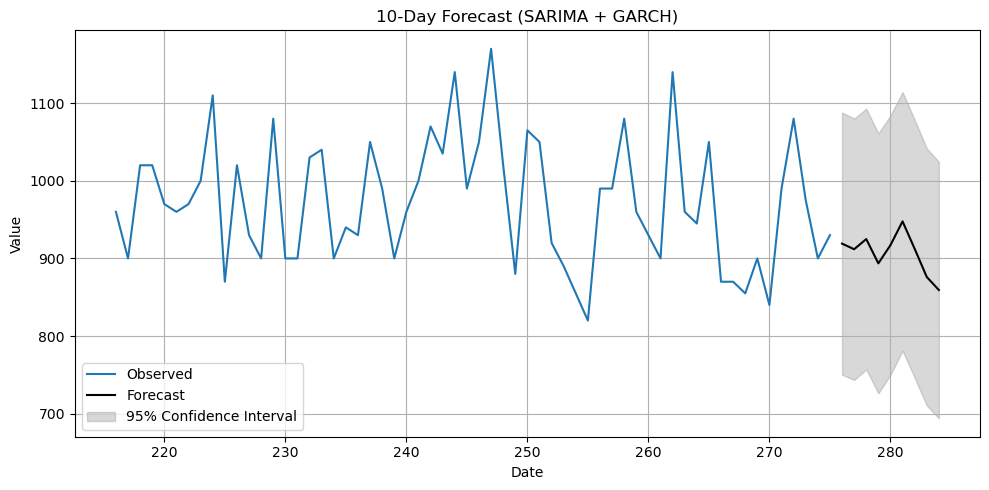

In [108]:
from scipy.stats import norm
horizon = 10
forecast_log = best_model.get_forecast(steps=horizon)
forecast_mean = forecast_log.predicted_mean
forecast_ci = forecast_log.conf_int()

garch_forecast = garch_results.forecast(horizon=horizon)
forecast_var = garch_forecast.variance.values[-1, :]
forecast_std = np.sqrt(forecast_var)

z = norm.ppf(0.975)  # 95% CI
lower_log = forecast_mean - z * forecast_std
upper_log = forecast_mean + z * forecast_std

# forecast_mean = np.exp(forecast_mean)
# lower = np.exp(lower_log)
# upper = np.exp(upper_log)

forecast_mean = forecast_mean
lower = lower_log
upper = upper_log

forecast_df = pd.DataFrame({
    'Forecast': forecast_mean,
    'Lower 95% CI': lower,
    'Upper 95% CI': upper
}, index=np.arange(feeding_ts.index[-1], feeding_ts.index[-1]+horizon))

print(forecast_df)

plt.figure(figsize=(10, 5))
plt.plot(feeding_ts[-60:], label='Observed')  # show last 60 days of original data
plt.plot(forecast_df['Forecast'], label='Forecast', color='black')
plt.fill_between(forecast_df.index, forecast_df['Lower 95% CI'], forecast_df['Upper 95% CI'],
                 color='gray', alpha=0.3, label='95% Confidence Interval')
plt.title('10-Day Forecast (SARIMA + GARCH)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

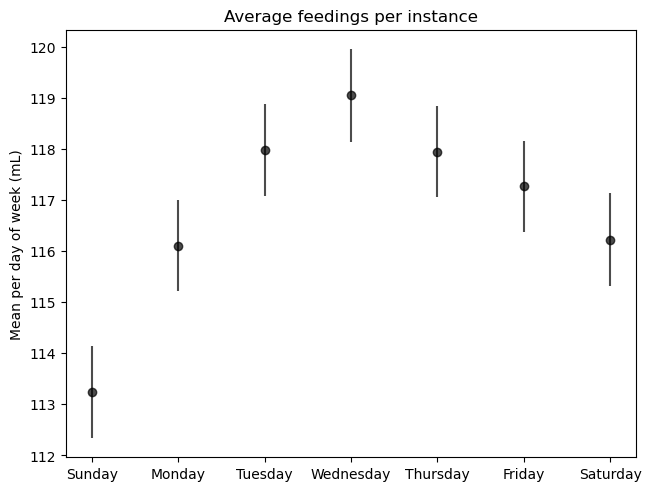

In [32]:
# Group and sum by day
daily_means = group_and_mean_by_day_of_week(get_type_data(full_df, 'bottle'), 'enteredDate', ['bottleAmount'],
                                            BOTTLE_ERR)

plt.errorbar(daily_means['day_of_week'],
             daily_means['bottleAmount_mean'],
             yerr=daily_means['bottleAmount_err'],
             **get_plot_kwargs('all'))
plt.title("Average feedings per instance")
plt.ylabel("Mean per day of week (mL)")
plt.savefig("figures/average_feeding_instance_week.png")

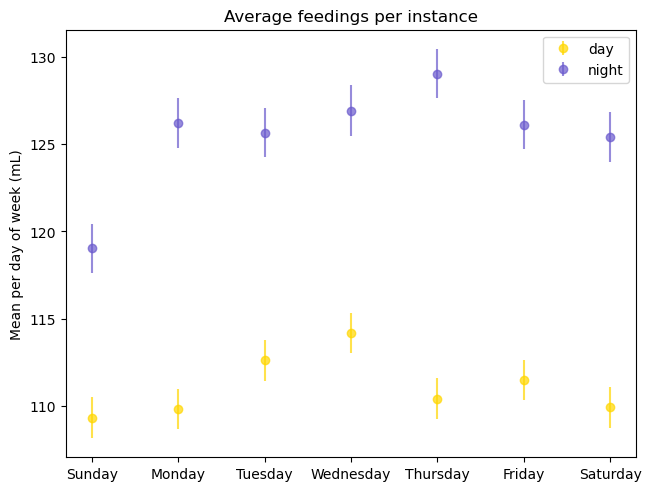

In [33]:
# Group and sum by day

df = categorize_day_night_start_only(get_type_data(full_df, 'bottle'), 'enteredDate')

for period in ['day','night']:
    daily_means = group_and_mean_by_day_of_week(get_timeperiod_data(df, period), 'enteredDate', ['bottleAmount'],
                                                BOTTLE_ERR)

    plt.errorbar(daily_means['day_of_week'],
                 daily_means['bottleAmount_mean'],
                 yerr=daily_means['bottleAmount_err'],
                 **get_plot_kwargs(period))


plt.legend()
plt.title("Average feedings per instance")
plt.ylabel("Mean per day of week (mL)")
plt.savefig("figures/average_feeding_instance_week_day_night.png")

In [34]:
df = get_type_data(full_df, 'bottle')
date_range = pd.date_range(start=df['enteredDate'].min().date(), end=df['enteredDate'].max().date())

### Feeding Heatmap

In [35]:
TIME_PERIODS = [
    ("2024-10-01", "2025-01-17", "21:00:00", "08:00:00"),
    ("2025-01-18", "2025-01-31", "20:00:00", "08:00:00"),
    ("2025-02-01", "2025-02-28", "19:00:00", "07:00:00"),
    ("2025-03-01", "2025-04-22", "17:45:00", "07:00:00"),
    ("2025-04-23", "2025-12-31", "18:15:00", "07:00:00")
]

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_64314/1708476797.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time
/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_64314/1708476797.py:136: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


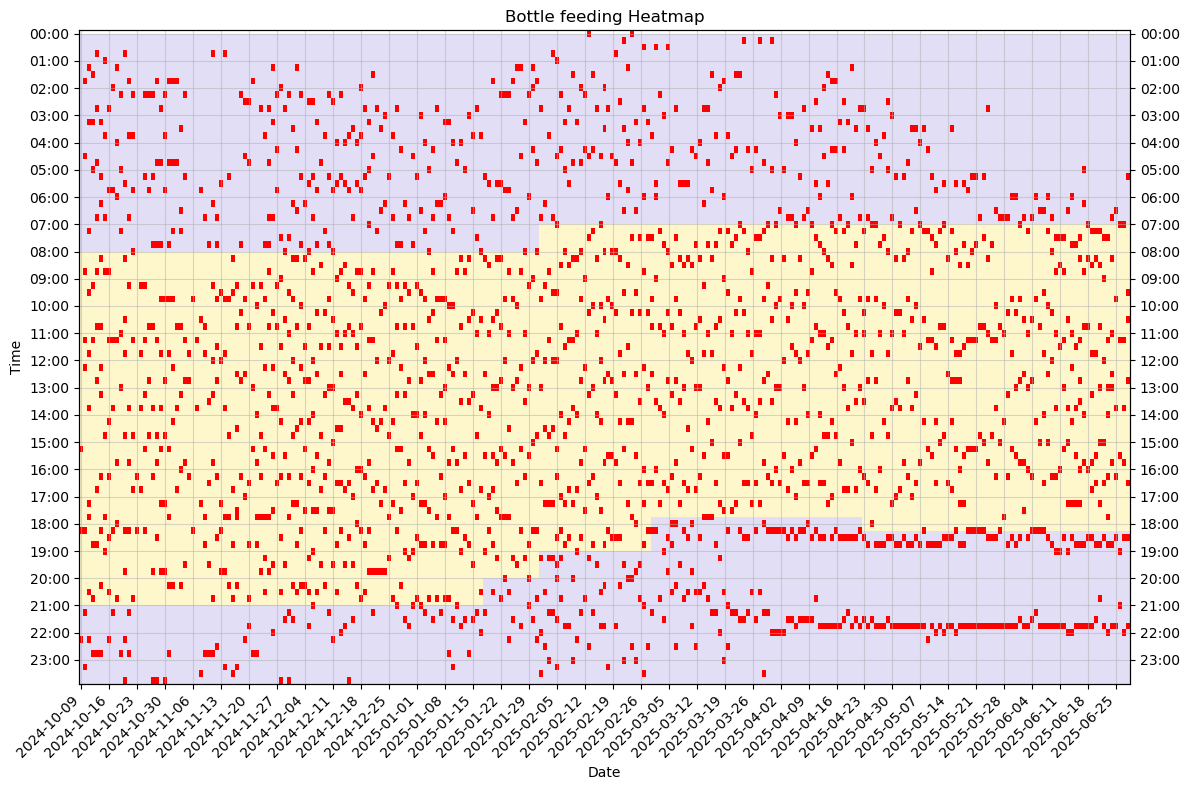

In [36]:
# Assuming you have a DataFrame 'df' with columns 'leftStart' and 'leftEnd'
# If not, you can create a sample DataFrame like this:
# df = pd.DataFrame({
#     'leftStart': pd.date_range(start='2023-01-01 09:00', end='2023-01-10 09:00', freq='D'),
#     'leftEnd': pd.date_range(start='2023-01-01 17:00', end='2023-01-10 17:00', freq='D')
# })

# Create a date range for x-axis
filtered_df = filter_date_range(full_df, 'enteredDate', custom_start_date, custom_end_date)
df = get_type_data(filtered_df, 'bottle')
date_range = pd.date_range(start=df['enteredDate'].min().date(), end=df['enteredDate'].max().date())

# Create time range for y-axis (24 hours, in 15-minute intervals)
time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time

# Create a 2D array to hold the heatmap data
heatmap_data = np.zeros((len(time_range), len(date_range)))

# Fill the heatmap data
for _, row in df.iterrows():
    start_date = row['enteredDate'].date()
    end_date = (row['enteredDate']+pd.Timedelta(15,'min')).date()
    start_time = row['enteredDate'].time()
    end_time = (row['enteredDate']+pd.Timedelta(15,'min')).time()
    # print(f"{row['leftStart']} to {row['leftEnd']} {row['leftEnd']-row['leftStart']}")
    
    date_idx_start = np.where(date_range.normalize() == pd.Timestamp(start_date).normalize())[0][0]
    date_idx_end = np.where(date_range.normalize() == pd.Timestamp(end_date).normalize())[0][0]
    
    start_idx = time_range.searchsorted(start_time)
    end_idx = time_range.searchsorted(end_time)
    
    if date_idx_start == date_idx_end:
        heatmap_data[start_idx:end_idx, date_idx_start] = 1
    else:
        heatmap_data[start_idx:, date_idx_start] = 1
        heatmap_data[:end_idx, date_idx_end] = 1
        if date_idx_end - date_idx_start > 1:
            heatmap_data[:, date_idx_start+1:date_idx_end] = 1

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

hour_time_step = 4
morning_start = 0  # 0:00
morning_start_object = datetime.datetime.strptime(MORNING_START, "%H:%M:%S").time()
morning_decimal_hour = morning_start_object.hour + morning_start_object.minute / 60 + morning_start_object.second / 3600
morning_end = morning_decimal_hour * hour_time_step

evening_start_object = datetime.datetime.strptime(NIGHT_START, "%H:%M:%S").time()
evening_start_decimal_hour = evening_start_object.hour + evening_start_object.minute / 60 + evening_start_object.second / 3600
evening_start = evening_start_decimal_hour * hour_time_step  # 18:00
evening_end = len(time_range)  # 23:59

# ax.axhspan(morning_start, morning_end, facecolor='slateblue', alpha=0.2)  # 0-7 hours
# ax.axhspan(morning_end, evening_start, facecolor='gold', alpha=0.2)  # 7-18 hours
# ax.axhspan(evening_start, evening_end, facecolor='slateblue', alpha=0.2)  # 18-24 hours
# Loop through each time period and apply the appropriate shading
for period_info in TIME_PERIODS:
    date_start, date_end, evening_start_time, morning_start_time = period_info

    # Find the column indices that correspond to the date range
    # Convert date strings to datetime objects
    start_date = pd.Timestamp(date_start).normalize()
    end_date = pd.Timestamp(date_end).normalize()

    # Find indices in date_range that fall within this period
    date_mask = (date_range.normalize() >= start_date) & (date_range.normalize() <= end_date)
    date_indices = np.where(date_mask)[0]

    if len(date_indices) == 0:
        continue  # Skip if no dates in this range

    # Get the start and end column indices
    col_start = date_indices[0]
    col_end = date_indices[-1]

    # Convert to plot coordinates (xmin and xmax are in 0-1 range)
    total_cols = len(date_range)
    xmin = col_start / total_cols
    xmax = (col_end + 1) / total_cols  # +1 to include the last column

    # Convert time strings to time objects and find row indices
    morning_start_obj = datetime.datetime.strptime(morning_start_time, "%H:%M:%S").time()
    evening_start_obj = datetime.datetime.strptime(evening_start_time, "%H:%M:%S").time()

    # Find row indices for these times
    morning_idx = time_range.searchsorted(morning_start_obj)
    evening_idx = time_range.searchsorted(evening_start_obj)
    evening_end_idx = len(time_range)

    # Create the shaded regions for morning, day, and evening using axhspan
    # For the night-morning period (midnight to morning_start)
    ax.axhspan(0, morning_idx, xmin=xmin, xmax=xmax,
               facecolor='slateblue', alpha=0.2, zorder=0)

    # For the day period (morning_start to evening_start)
    ax.axhspan(morning_idx, evening_idx, xmin=xmin, xmax=xmax,
               facecolor='gold', alpha=0.2, zorder=0)

    # For the night-evening period (evening_start to midnight)
    ax.axhspan(evening_idx, evening_end_idx, xmin=xmin, xmax=xmax,
               facecolor='slateblue', alpha=0.2, zorder=0)

# Create custom colormap (white for 0, blue for 1)
cmap = ListedColormap(['none', 'red'])

# Plot the heatmap
im = ax.imshow(heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')

# Set x-axis ticks and labels
num_dates = len(date_range)
tick_interval = morning_decimal_hour  #num_dates // 25 # Use integer division to get 1/4 of the ticks
tick_positions = np.arange(0, num_dates, tick_interval, dtype=int)
ax.set_xticks(tick_positions)
ax.set_xticklabels([date_range[i].strftime('%Y-%m-%d') for i in tick_positions], rotation=45, ha='right')

# Set y-axis ticks and labels (every hour)
hour_indices = np.arange(0, len(time_range), 4)
ax.set_yticks(hour_indices)
ax.set_yticklabels([t.strftime('%H:%M') for t in time_range[hour_indices]])

ax2 = ax.twinx()  # Create twin axis on the right side
ax2.set_yticks(ax.get_yticks())  # Copy the y-ticks from left axis
ax2.set_yticklabels(ax.get_yticklabels())  # Copy the y-tick labels
ax2.set_ylim(ax.get_ylim())

ax.grid(True, alpha=0.5)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Time')
ax.set_title('Bottle feeding Heatmap')

# Adjust layout and display the plot
plt.tight_layout()

plt.savefig("figures/bottle_map.png")
plt.show()

/Users/deividribeiro/Documents/Work/Projects/Baby/realm/helper_methods.py:674: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time
/Users/deividribeiro/Documents/Work/Projects/Baby/realm/helper_methods.py:807: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


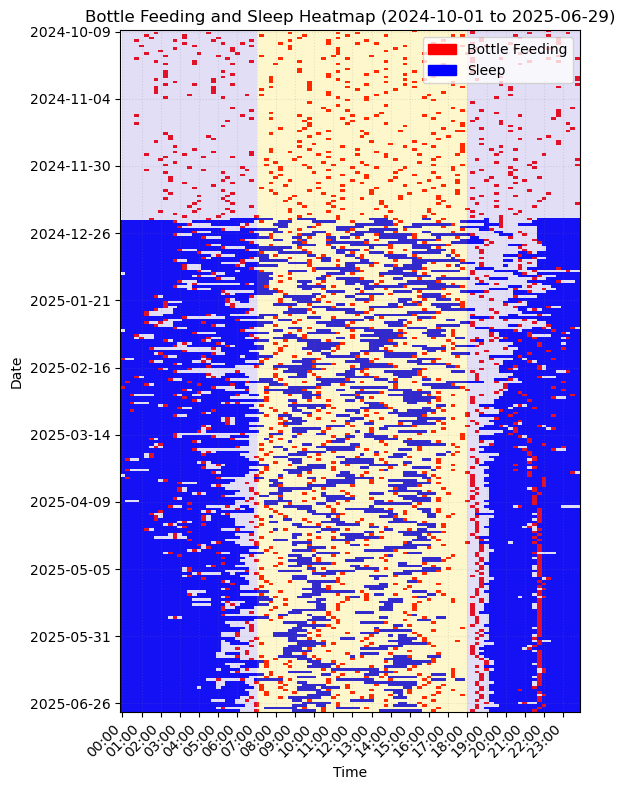

In [37]:
# Function to limit the display to a specific date range

# Usage example:
# Plot for a specific date range
ax = plot_heatmap_with_date_range(full_df,custom_start_date, custom_end_date)

# plt.sca(ax)
# plt.savefig("figures/bottle_sleep_heatmap.png")
# Or to plot the entire range
# plot_heatmap_with_date_range(min_date.strftime('%Y-%m-%d'), max_date.strftime('%Y-%m-%d'))

## Sleeping

Sleep is one of the most critical aspects of infant development. This section analyzes:
- Total sleep duration per day
- Sleep session length distribution
- Day vs. night sleep patterns
- Correlations between day and night sleep
- Visual representation of sleep times using heatmaps

We can observe how sleep patterns evolve over time and identify any day-of-week preferences for longer/shorter sleep.

### Sleep Durations

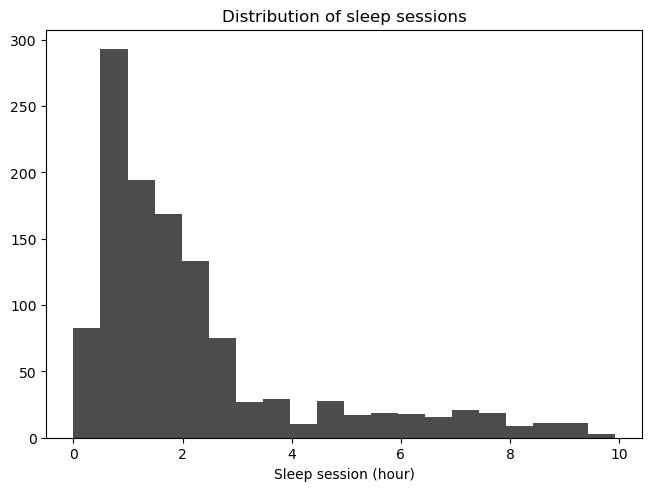

In [38]:
sleep_durations = get_type_data(full_df, 'sleep')[['singleTimerSeconds']].values

plt.hist(sleep_durations / 3600, bins=20, **get_plot_kwargs('all', plot_type='histogram'))
plt.xlabel("Sleep session (hour)")
plt.title("Distribution of sleep sessions")
plt.savefig("figures/sleep_dist.png")

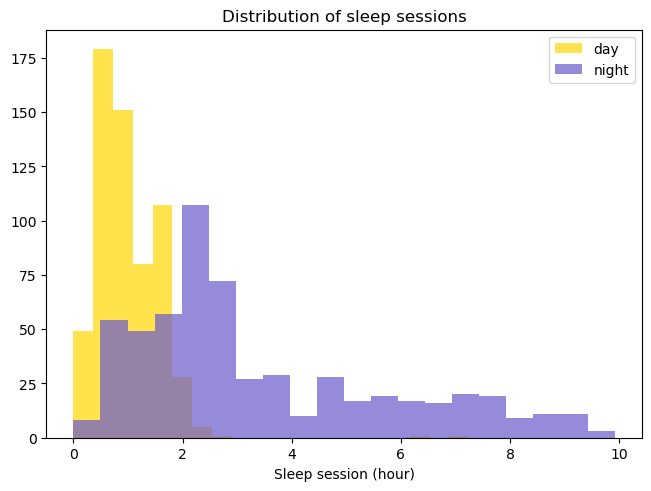

In [39]:
df = categorize_day_night_start_only(get_type_data(full_df, 'sleep'), 'leftStart')
for period in ['day','night']:
    sleep_durations = get_timeperiod_data(df, period)[['singleTimerSeconds']].values
    plt.hist(sleep_durations / 3600, bins=20, **get_plot_kwargs(period, plot_type='histogram'))

plt.legend()
plt.xlabel("Sleep session (hour)")
plt.title("Distribution of sleep sessions")
plt.savefig("figures/sleep_dist_day_night.png")

### Sleep over time, per day

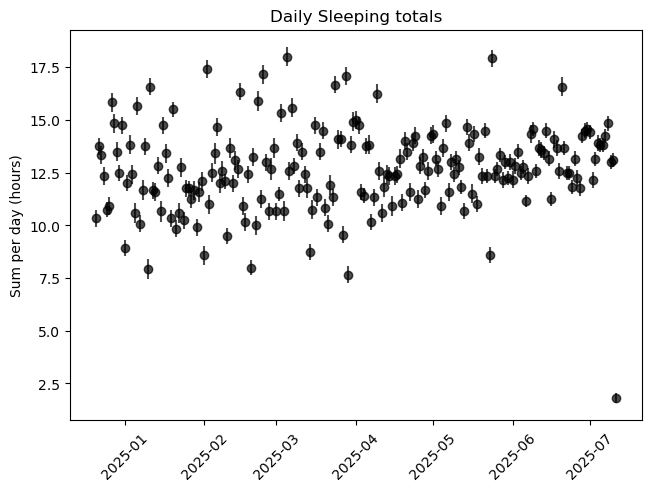

In [40]:
# Group and sum by day
daily_totals = group_and_sum_by_day(get_type_data(full_df, 'sleep'), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)

# Add day of week
daily_totals_with_day = add_day_of_week(daily_totals, 'leftStart')

plt.errorbar(daily_totals['leftStart'],
             daily_totals['singleTimerSeconds_sum'] / 3600,
             yerr=daily_totals['singleTimerSeconds_err']/3600,
             **get_plot_kwargs('all'))
plt.title("Daily Sleeping totals")
plt.xticks(rotation=45)
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/daily_sleep.png")

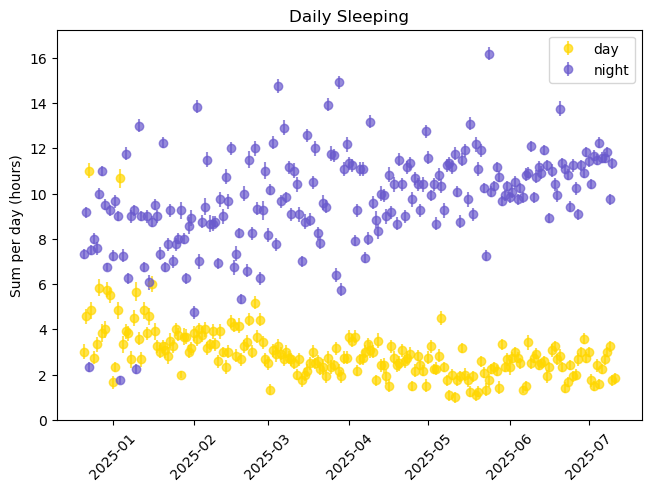

In [41]:
# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df, 'sleep'), 'leftStart')

for period in ['day','night']:
    daily_totals = group_and_sum_by_day(get_timeperiod_data(df, period), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)
    plt.errorbar(daily_totals['leftStart'],
                 daily_totals['singleTimerSeconds_sum'] / 3600,
                 yerr=daily_totals['singleTimerSeconds_err']/3600,
                 **get_plot_kwargs(period))
plt.legend()
plt.xticks(rotation=45)
plt.title("Daily Sleeping")
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/daily_sleep_day_night.png")

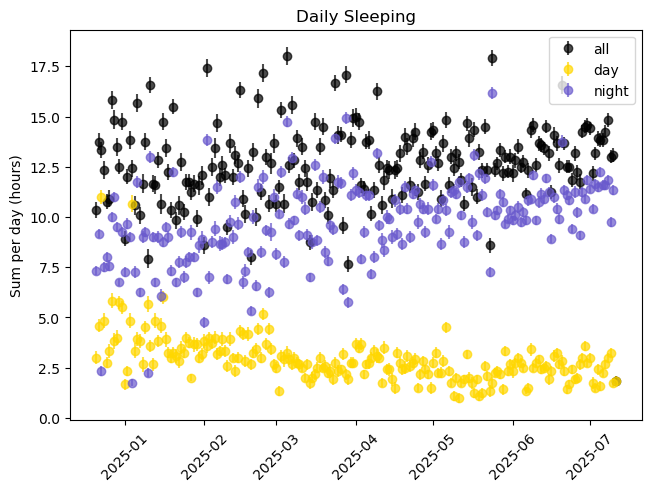

In [42]:
# Group and sum by day
daily_totals = group_and_sum_by_day(get_type_data(full_df, 'sleep'), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)

# Add day of week
daily_totals_with_day = add_day_of_week(daily_totals, 'leftStart')

plt.errorbar(daily_totals['leftStart'],
             daily_totals['singleTimerSeconds_sum'] / 3600,
             yerr=daily_totals['singleTimerSeconds_err']/3600,
             **get_plot_kwargs('all'))

# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df, 'sleep'), 'leftStart')

for period in ['day','night']:
    daily_totals = group_and_sum_by_day(get_timeperiod_data(df, period), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)
    plt.errorbar(daily_totals['leftStart'],
                 daily_totals['singleTimerSeconds_sum'] / 3600,
                 yerr=daily_totals['singleTimerSeconds_err']/3600,
                 **get_plot_kwargs(period))
plt.legend()
plt.xticks(rotation=45)
plt.title("Daily Sleeping")
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/daily_sleep_day_night_all.png")

### Stroller

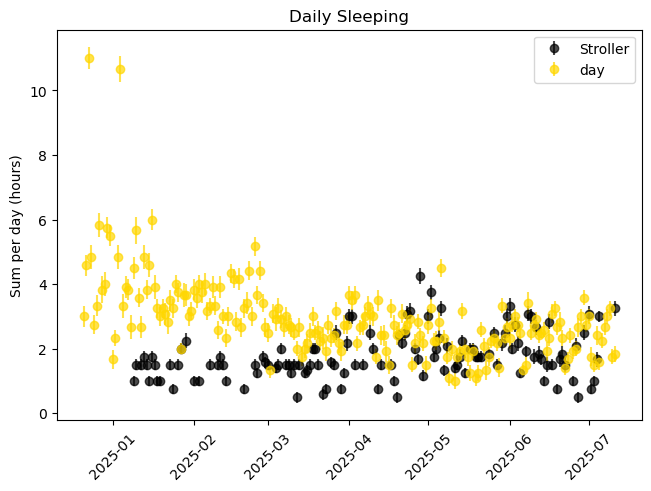

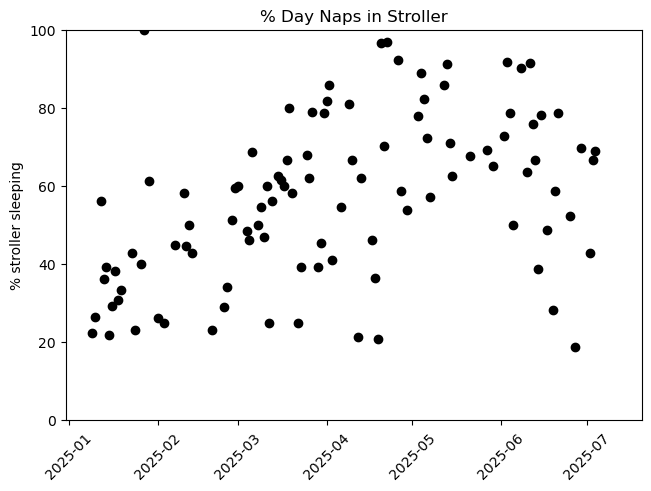

In [43]:
# Group and sum by day
daily_totals_stroller = group_and_sum_durations_by_day(get_type_data(full_df, 'stroll'), ['leftStart', 'leftEnd'], error_value=SLEEP_ERR)

# Add day of week
daily_totals_stroller_with_day = add_day_of_week(daily_totals_stroller, 'leftStart')

plt.errorbar(daily_totals_stroller['leftStart'],
             daily_totals_stroller['event_duration_sum'] / 3600,
             yerr=daily_totals_stroller['event_duration_sum_err']/3600,
             **get_plot_kwargs('all', custom_label='Stroller'))

# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df, 'sleep'), 'leftStart')

for period in ['day']:
    daily_totals = group_and_sum_by_day(get_timeperiod_data(df, period), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)
    plt.errorbar(daily_totals['leftStart'],
                 daily_totals['singleTimerSeconds_sum'] / 3600,
                 yerr=daily_totals['singleTimerSeconds_err']/3600,
                 **get_plot_kwargs(period))
plt.legend()
plt.title("Daily Sleeping")
plt.xticks(rotation=45)
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/daily_sleep_stroller.png")

merged_df = pd.merge(daily_totals_stroller, daily_totals,'inner')
plt.figure()
plt.plot(merged_df['leftStart'],
         merged_df['event_duration_sum']/merged_df['singleTimerSeconds_sum']*100,
         marker='o',
         color='k', ls='None'
        )
plt.ylim(0,100)
plt.ylabel("% stroller sleeping")
plt.xticks(rotation=45)
plt.title("% Day Naps in Stroller")
plt.savefig("figures/daily_sleep_stroller_percent.png")

### Sleep per day of week

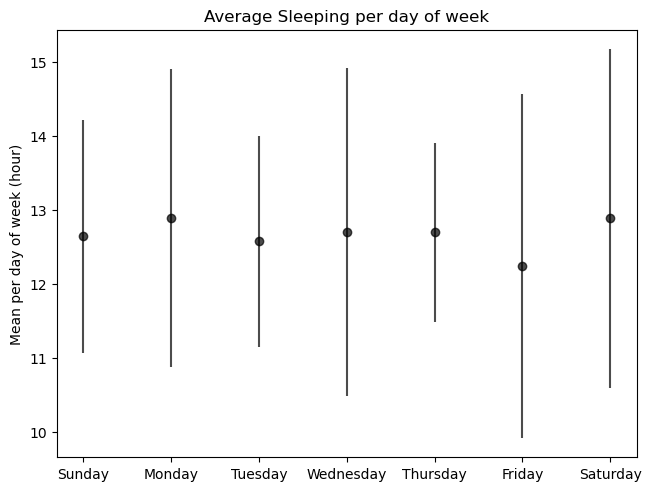

In [44]:
# Group and sum by day
filtered_df = filter_date_range(full_df, 'leftStart', custom_start_date, custom_end_date)
daily_means = group_and_mean_sums_by_day_of_week(get_type_data(filtered_df, 'sleep'), 'leftStart', ['singleTimerSeconds'],
                                                 SLEEP_ERR)

plt.errorbar(daily_means['day_of_week'],
             daily_means['singleTimerSeconds_sum_mean'] / 3600,
             yerr=daily_means['singleTimerSeconds_sum_std']/3600,
             **get_plot_kwargs('all'))
plt.title("Average Sleeping per day of week")
plt.ylabel("Mean per day of week (hour)")
plt.savefig("figures/sleep_per_weekday.png")

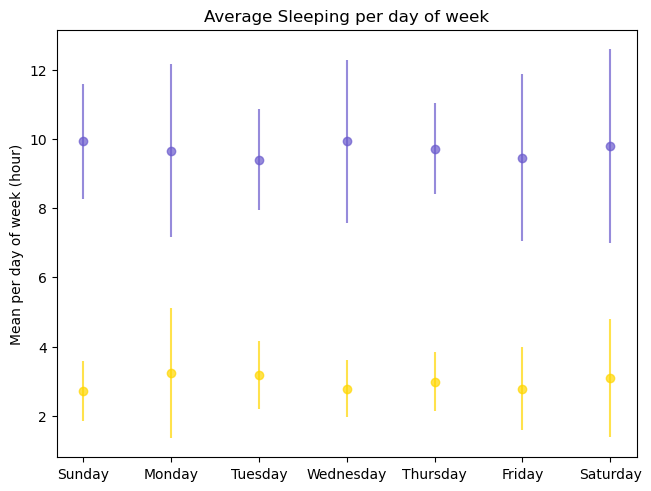

In [45]:
# Group and sum by day
for period in ['day','night']:
    filtered_df = filter_date_range(full_df, 'leftStart', custom_start_date, custom_end_date)
    filtered_df = categorize_day_night_start_only(filtered_df, 'leftStart')

    daily_means = group_and_mean_sums_by_day_of_week(get_type_data(get_timeperiod_data(filtered_df,period), 'sleep'), 'leftStart', ['singleTimerSeconds'],
                                                 SLEEP_ERR)

    plt.errorbar(daily_means['day_of_week'],
                 daily_means['singleTimerSeconds_sum_mean'] / 3600,
                 yerr=daily_means['singleTimerSeconds_sum_std']/3600,
                 **get_plot_kwargs(period))
plt.title("Average Sleeping per day of week")
plt.ylabel("Mean per day of week (hour)")
plt.savefig("figures/sleep_per_weekday_day_night.png")

### How does sum of night sleep impact sum of following day's sleep. Plot night sum vs day sum. Is there a trend line?

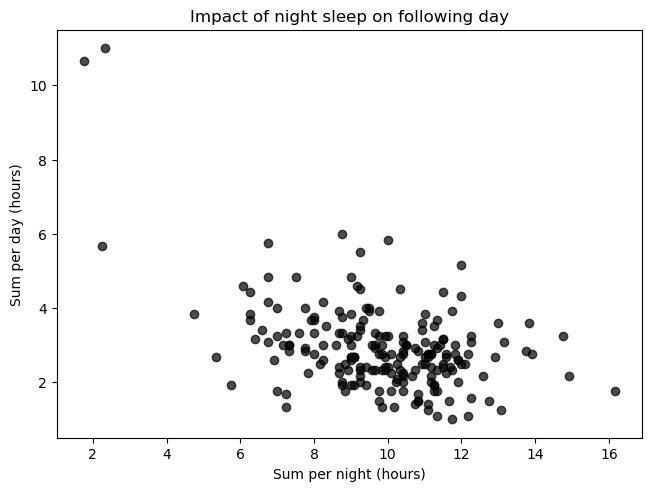

In [46]:
# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df, 'sleep'), 'leftStart')
daily_totals_night = group_and_sum_by_day(get_timeperiod_data(df, 'night'), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)
daily_totals_day = group_and_sum_by_day(get_timeperiod_data(df, 'day'), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)
combined_df = daily_totals_night.merge(daily_totals_day,how='inner',on= "leftStart")
plt.plot(combined_df['singleTimerSeconds_sum_x'] / 3600,
         combined_df['singleTimerSeconds_sum_y'] / 3600,
         **get_plot_kwargs('all'))

plt.title("Impact of night sleep on following day")
plt.xlabel("Sum per night (hours)")
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/sleep_night_on_day.png")

### How does sum of day sleep impact sum of following night's sleep. Plot day sum vs night sum. Is there a trend line?

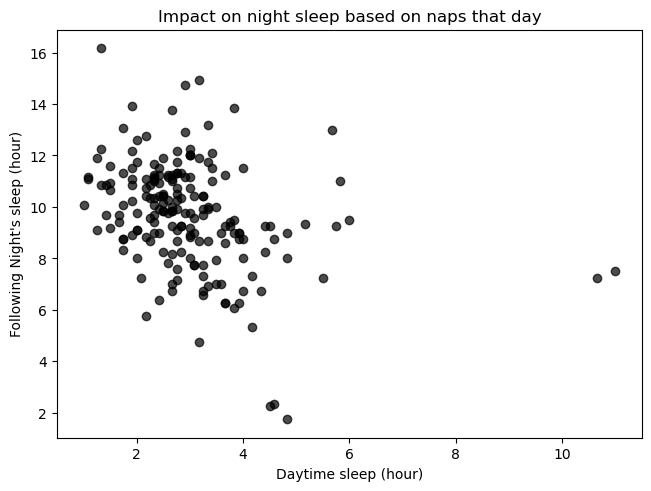

In [47]:
# Group and sum by day
filtered_df = filter_date_range(full_df, 'leftStart', custom_start_date, custom_end_date)
df = categorize_day_night_start_only(get_type_data(filtered_df, 'sleep'), 'leftStart')

daily_totals_night = group_and_sum_by_day(get_timeperiod_data(df, 'night'), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)
daily_totals_day = group_and_sum_by_day(get_timeperiod_data(df, 'day'), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)

results = get_consecutive_durations_from_two_dfs(daily_totals_day, daily_totals_night, date_column='leftStart', duration_column='singleTimerSeconds_sum')
plt.plot(results[:,1] / 3600,results[:,3] / 3600, **get_plot_kwargs('all'))

plt.xlabel("Daytime sleep (hour)")
plt.ylabel("Following Night's sleep (hour)")
plt.title("Impact on night sleep based on naps that day")
plt.savefig("figures/sleep_day_on_night.png")

### Sleep heatmap

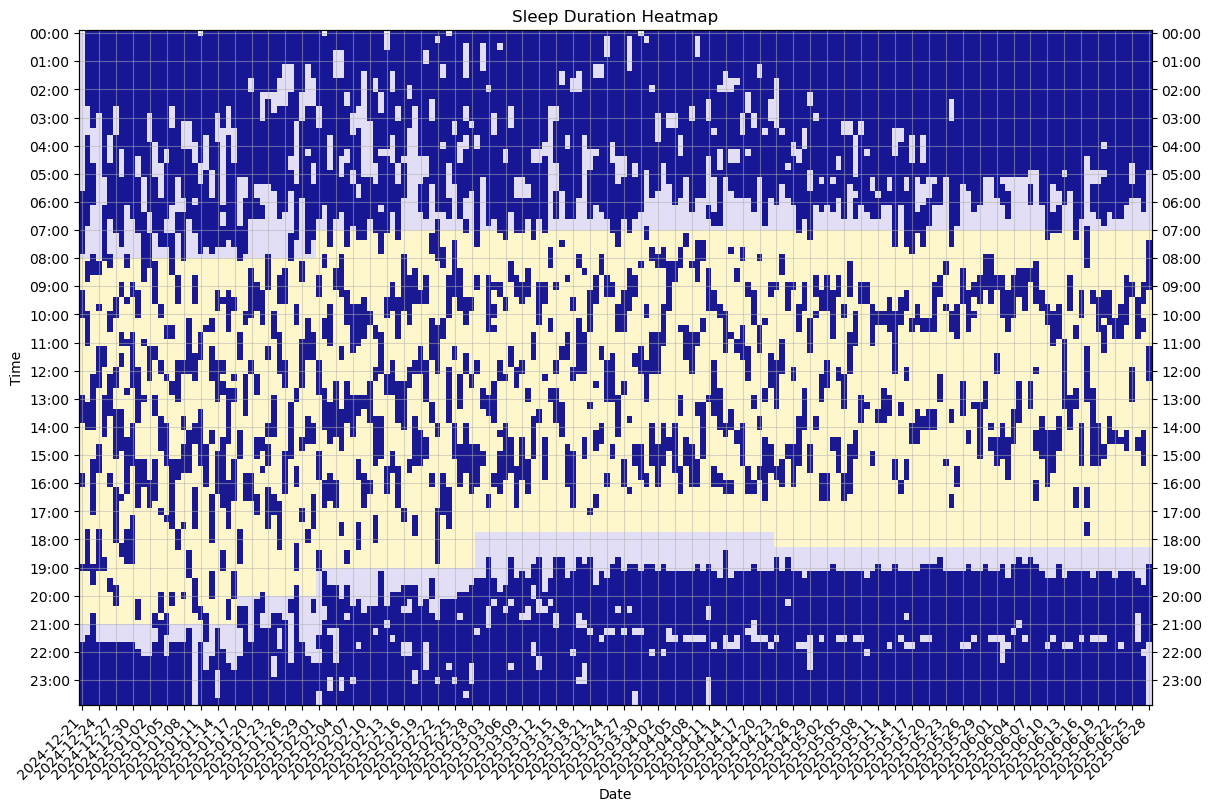

In [48]:
# Assuming you have a DataFrame 'df' with columns 'leftStart' and 'leftEnd'
# If not, you can create a sample DataFrame like this:
# df = pd.DataFrame({
#     'leftStart': pd.date_range(start='2023-01-01 09:00', end='2023-01-10 09:00', freq='D'),
#     'leftEnd': pd.date_range(start='2023-01-01 17:00', end='2023-01-10 17:00', freq='D')
# })

# Create a date range for x-axis
filtered_df = filter_date_range(full_df, 'enteredDate', custom_start_date, custom_end_date)

df = get_type_data(filtered_df, 'sleep')
date_range = pd.date_range(start=df['leftStart'].min().date(), end=df['leftEnd'].max().date())

# Create time range for y-axis (24 hours, in 15-minute intervals)
time_range = pd.date_range(start='00:00', end='23:59', freq='15min').time

# Create a 2D array to hold the heatmap data
heatmap_data = np.zeros((len(time_range), len(date_range)))

# Fill the heatmap data
for _, row in df.iterrows():
    start_date = row['leftStart'].date()
    end_date = row['leftEnd'].date()
    start_time = row['leftStart'].time()
    end_time = row['leftEnd'].time()
    # print(f"{row['leftStart']} to {row['leftEnd']} {row['leftEnd']-row['leftStart']}")
    
    date_idx_start = np.where(date_range.normalize() == pd.Timestamp(start_date).normalize())[0][0]
    date_idx_end = np.where(date_range.normalize() == pd.Timestamp(end_date).normalize())[0][0]
    
    start_idx = time_range.searchsorted(start_time)
    end_idx = time_range.searchsorted(end_time)
    
    if date_idx_start == date_idx_end:
        heatmap_data[start_idx:end_idx, date_idx_start] = 1
    else:
        heatmap_data[start_idx:, date_idx_start] = 1
        heatmap_data[:end_idx, date_idx_end] = 1
        if date_idx_end - date_idx_start > 1:
            heatmap_data[:, date_idx_start+1:date_idx_end] = 1

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

hour_time_step = 4

# Loop through each time period and apply the appropriate shading
for period_info in TIME_PERIODS:
    date_start, date_end, evening_start_time, morning_start_time = period_info

    # Find the column indices that correspond to the date range
    # Convert date strings to datetime objects
    start_date = pd.Timestamp(date_start).normalize()
    end_date = pd.Timestamp(date_end).normalize()

    # Find indices in date_range that fall within this period
    date_mask = (date_range.normalize() >= start_date) & (date_range.normalize() <= end_date)
    date_indices = np.where(date_mask)[0]

    if len(date_indices) == 0:
        continue  # Skip if no dates in this range

    # Get the start and end column indices
    col_start = date_indices[0]
    col_end = date_indices[-1]

    # Convert to plot coordinates (xmin and xmax are in 0-1 range)
    total_cols = len(date_range)
    xmin = col_start / total_cols
    xmax = (col_end + 1) / total_cols  # +1 to include the last column

    # Convert time strings to time objects and find row indices
    morning_start_obj = datetime.datetime.strptime(morning_start_time, "%H:%M:%S").time()
    evening_start_obj = datetime.datetime.strptime(evening_start_time, "%H:%M:%S").time()

    # Find row indices for these times
    morning_idx = time_range.searchsorted(morning_start_obj)
    evening_idx = time_range.searchsorted(evening_start_obj)
    evening_end_idx = len(time_range)

    # Create the shaded regions for morning, day, and evening using axhspan
    # For the night-morning period (midnight to morning_start)
    ax.axhspan(0, morning_idx, xmin=xmin, xmax=xmax,
               facecolor='slateblue', alpha=0.2, zorder=0)

    # For the day period (morning_start to evening_start)
    ax.axhspan(morning_idx, evening_idx, xmin=xmin, xmax=xmax,
               facecolor='gold', alpha=0.2, zorder=0)

    # For the night-evening period (evening_start to midnight)
    ax.axhspan(evening_idx, evening_end_idx, xmin=xmin, xmax=xmax,
               facecolor='slateblue', alpha=0.2, zorder=0)

# Create custom colormap (white for 0, blue for 1)
cmap = ListedColormap(['none', 'darkblue'])

# Plot the heatmap
im = ax.imshow(heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest', alpha=0.9)

# Set x-axis ticks and labels
num_dates = len(date_range)
tick_interval = 3 #num_dates // 25 # Use integer division to get 1/4 of the ticks
tick_positions = np.arange(0, num_dates, tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(date_range[tick_positions].strftime('%Y-%m-%d'), rotation=45, ha='right')

# Set y-axis ticks and labels (every hour)
hour_indices = np.arange(0, len(time_range), 4)
ax.set_yticks(hour_indices)
ax.set_yticklabels([t.strftime('%H:%M') for t in time_range[hour_indices]])

ax2 = ax.twinx()  # Create twin axis on the right side
ax2.set_yticks(ax.get_yticks())  # Copy the y-ticks from left axis
ax2.set_yticklabels(ax.get_yticklabels())  # Copy the y-tick labels
ax2.set_ylim(ax.get_ylim())

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Time')
ax.set_title('Sleep Duration Heatmap')

ax.grid(True, alpha=0.5)

# Add colorbar
# cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
# cbar.set_ticklabels(['Awake', 'Sleeping'])

# Adjust layout and display the plot
# plt.tight_layout()

plt.savefig("figures/sleep_map.png")
plt.show()

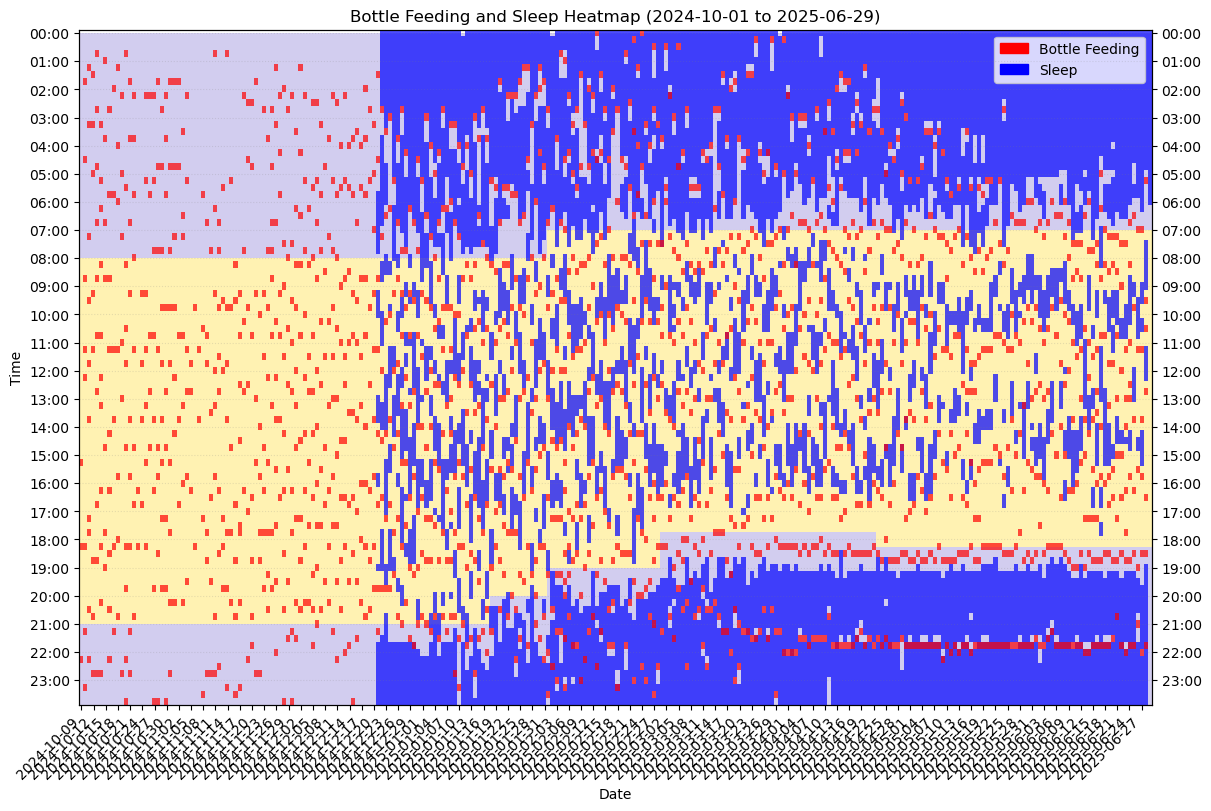

In [49]:
# '2024-12-21

ax = plot_heatmap_with_date_range_transpose(full_df, custom_start_date, custom_end_date)

plt.sca(ax)
plt.savefig("figures/bottle_sleep_heatmap.png")

# Or to plot the entire range
# plot_heatmap_with_date_range(min_date.strftime('%Y-%m-%d'), max_date.strftime('%Y-%m-%d'))

In [50]:
combined_df = full_df[(full_df['type']=='sleep') | (full_df['type']=='bottle')]
combined_df['combined_date'] = combined_df.apply(lambda row: row['leftStart'] if row['type'] == 'sleep' else row['enteredDate'], axis=1)
combined_df['combined_date'] = pd.to_datetime(combined_df['combined_date'])
df_sorted = combined_df.sort_values(by='combined_date')



## Vitals

This section tracks physical growth measurements including:
- Weight progression
- Height/length increases
- Head circumference growth

These measurements help ensure the baby is developing at a healthy rate and can identify any growth spurts or slowdowns.

### Growth

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_64314/823976067.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels, rotation=45, ha='right')
/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_64314/823976067.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels, rotation=45, ha='right')
/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_64314/823976067.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels, rotation=45, ha='right')
/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_64314/823976067.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


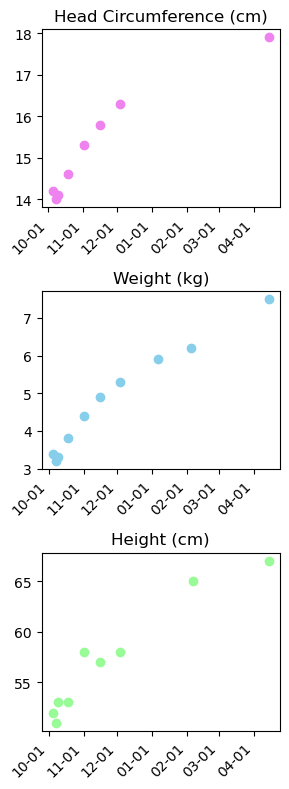

In [51]:
head_circ = get_type_data(full_df, "head_circ")[['enteredDate', 'headCircInches']]
weight = get_type_data(full_df, "weight")[['enteredDate', 'weight']]
height = get_type_data(full_df, "height")[['enteredDate', 'height']]

fig,ax=plt.subplots(3,1, figsize=(3,8))

ax[0].plot(head_circ.values[:,0], head_circ.values[:,1], label='head_circ',marker='o',ls='None', c='violet')
ax[1].plot(weight.values[:,0], weight.values[:,1], label='weight',marker='o',ls='None', c='skyblue')
ax[2].plot(height.values[:,0], height.values[:,1], label='height',marker='o',ls='None', c='palegreen')


ax[0].set_title("Head Circumference (cm)",)
ax[1].set_title("Weight (kg)")
ax[2].set_title("Height (cm)")

date_formatter = mdates.DateFormatter("%m-%d")
for i in range(3):
    # Format x-axis to show only month-day
    ax[i].xaxis.set_major_formatter(date_formatter)

    # Get current tick labels
    labels = ax[i].get_xticklabels()

    # Set the rotated labels
    ax[i].set_xticklabels(labels, rotation=45, ha='right')
    # ax[i].set_xticklabels(ax[i].get_xticks(), rotation = 45)

plt.tight_layout()
plt.savefig("figures/growth.png")

In [52]:
get_type_data(full_df, "height")[['enteredDate', 'height']]

,enteredDate,height
992,2024-10-04 12:00:55-04:00,52.0
993,2024-10-07 12:00:22-04:00,51.0
994,2024-10-09 12:00:44-04:00,53.0
995,2024-10-18 12:00:04-04:00,53.0
996,2024-11-01 12:00:21-04:00,58.0
997,2024-11-15 12:00:44-05:00,57.0
998,2024-12-03 12:00:04-05:00,58.0
2088,2025-02-06 11:33:52.852000-05:00,65.0
3333,2025-04-14 13:00:10-04:00,67.0


In [53]:
get_type_data(full_df, "height")[['enteredDate', 'height']].values[:, 0]

array([Timestamp('2024-10-04 12:00:55-0400', tz='US/Eastern'),
       Timestamp('2024-10-07 12:00:22-0400', tz='US/Eastern'),
       Timestamp('2024-10-09 12:00:44-0400', tz='US/Eastern'),
       Timestamp('2024-10-18 12:00:04-0400', tz='US/Eastern'),
       Timestamp('2024-11-01 12:00:21-0400', tz='US/Eastern'),
       Timestamp('2024-11-15 12:00:44-0500', tz='US/Eastern'),
       Timestamp('2024-12-03 12:00:04-0500', tz='US/Eastern'),
       Timestamp('2025-02-06 11:33:52.852000-0500', tz='US/Eastern'),
       Timestamp('2025-04-14 13:00:10-0400', tz='US/Eastern')],
      dtype=object)

## Wellbeing

This section tracks various aspects of daily care and health:
- Bath frequency and patterns
- Medication administration (gas drops)
- Diaper changes (frequency and type)

These visualizations help identify patterns in routine care activities and can help optimize scheduling.

### Baths

32


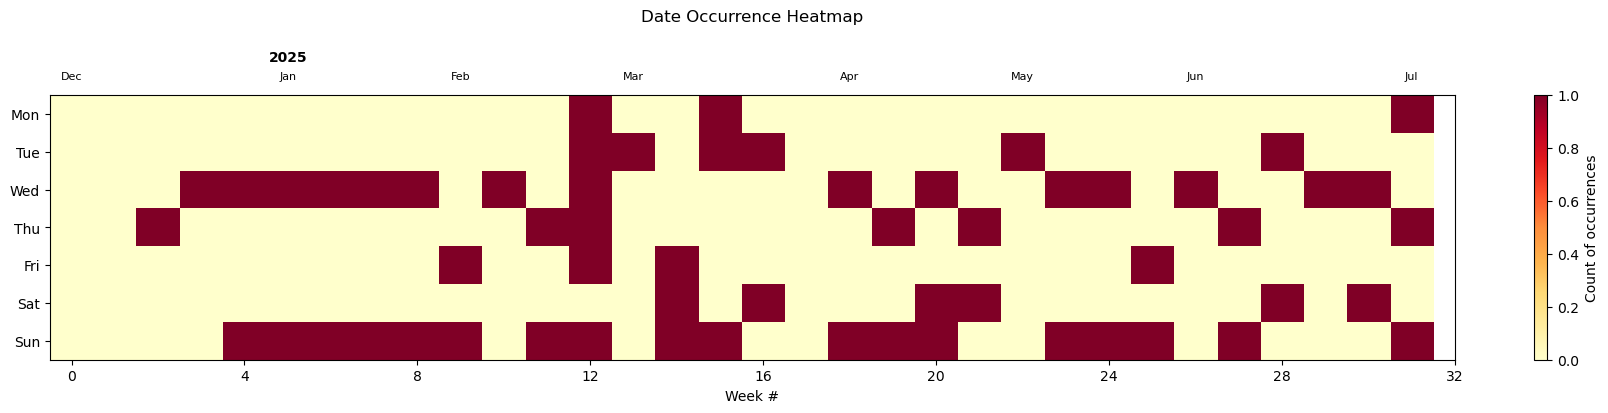

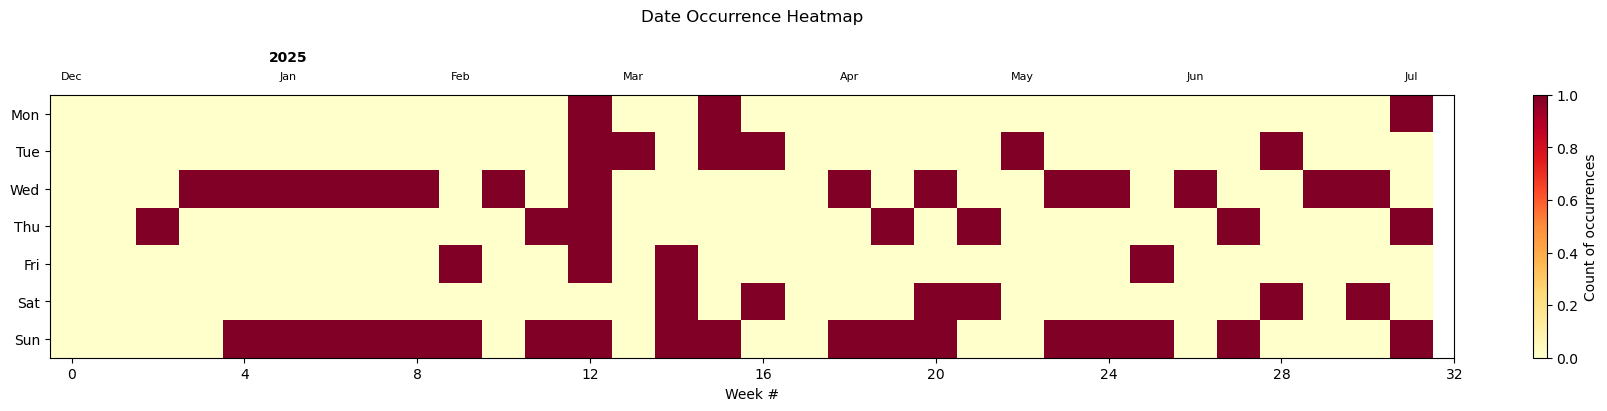

In [54]:
# Convert Series to list of dates
dates = get_type_data(full_df, "bathing")['enteredDate'].dt.date
ax = make_year_heatmap(dates)
plt.sca(ax)
plt.savefig("figures/bath_map.png")

### Gas Drops

41


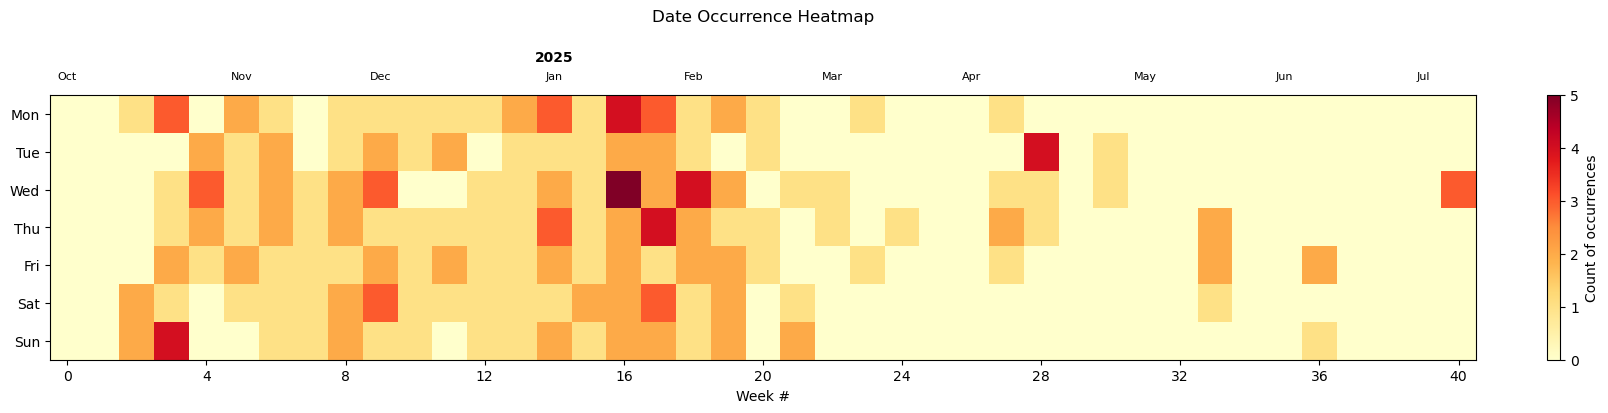

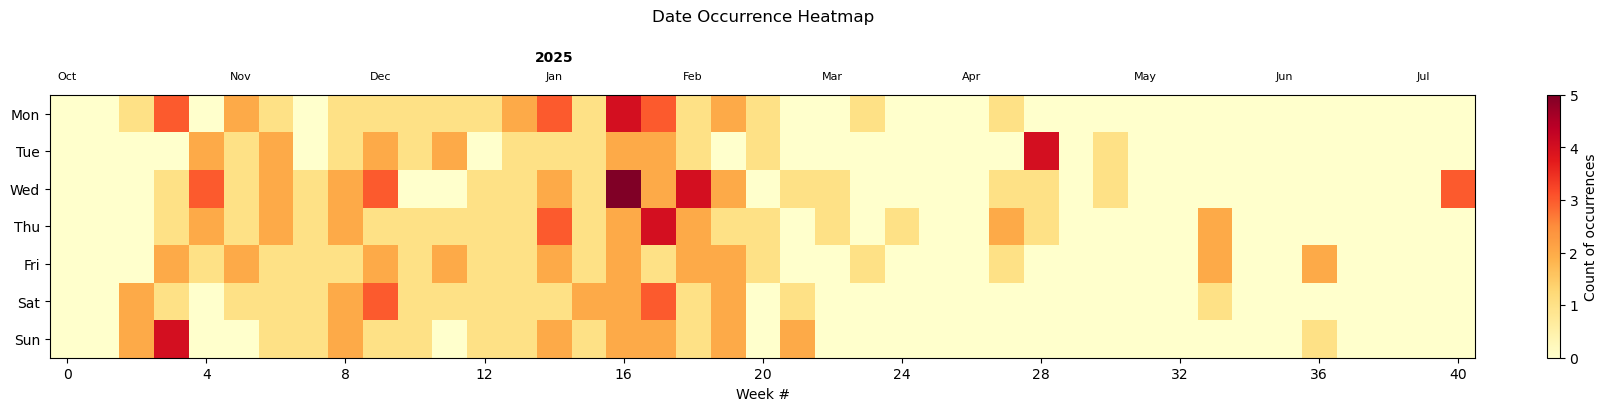

In [55]:
# Convert Series to list of dates
dates = get_type_data(full_df, "taking_med")['enteredDate'].dt.date
ax = make_year_heatmap(dates)
plt.sca(ax)
plt.savefig("figures/gas_drops_map.png")

### Diapers

41


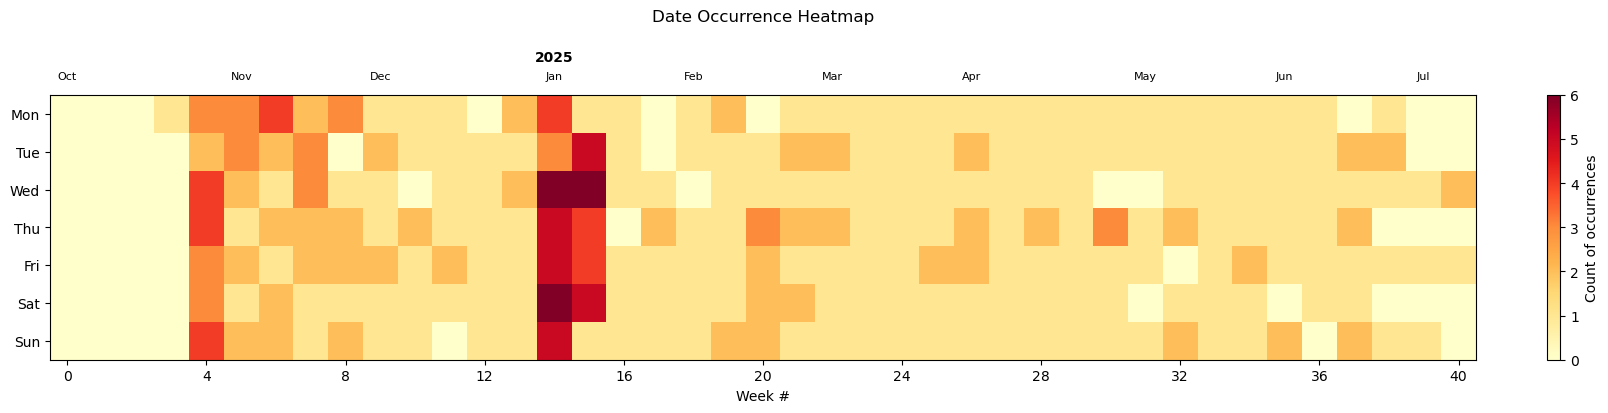

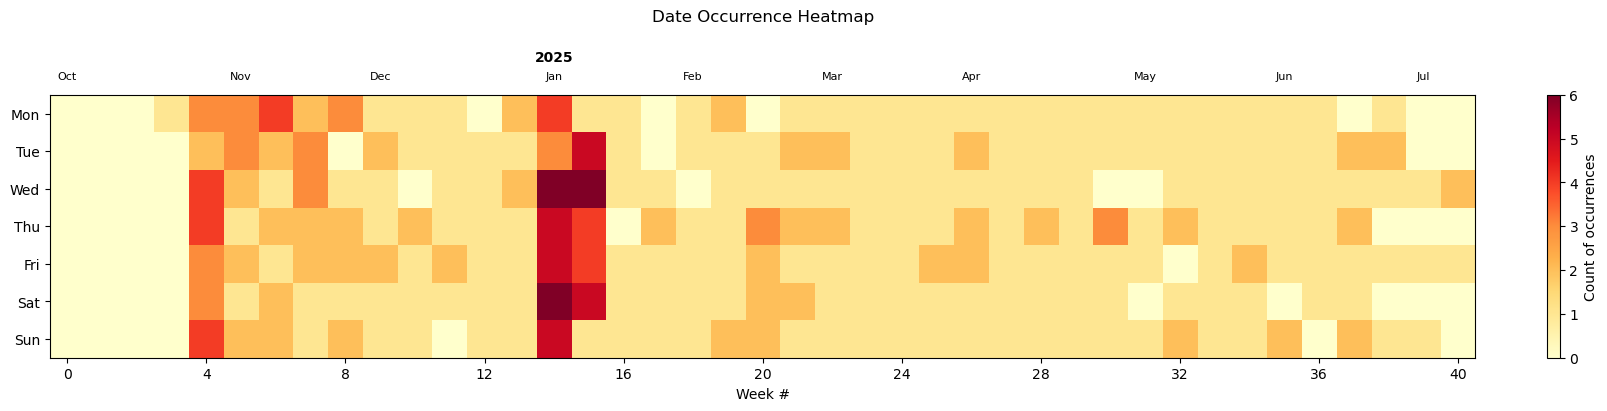

In [56]:
# Convert Series to list of dates
dates = get_type_data(full_df, "diaper")['enteredDate'].dt.date
ax= make_year_heatmap(dates)
plt.sca(ax)
plt.savefig("figures/diapers_map.png")

41


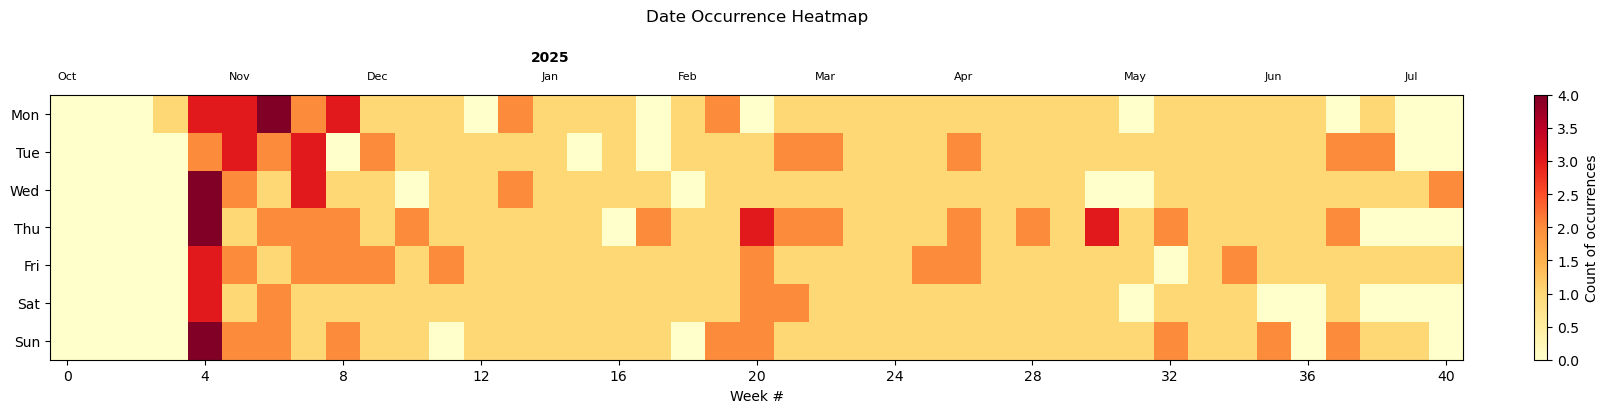

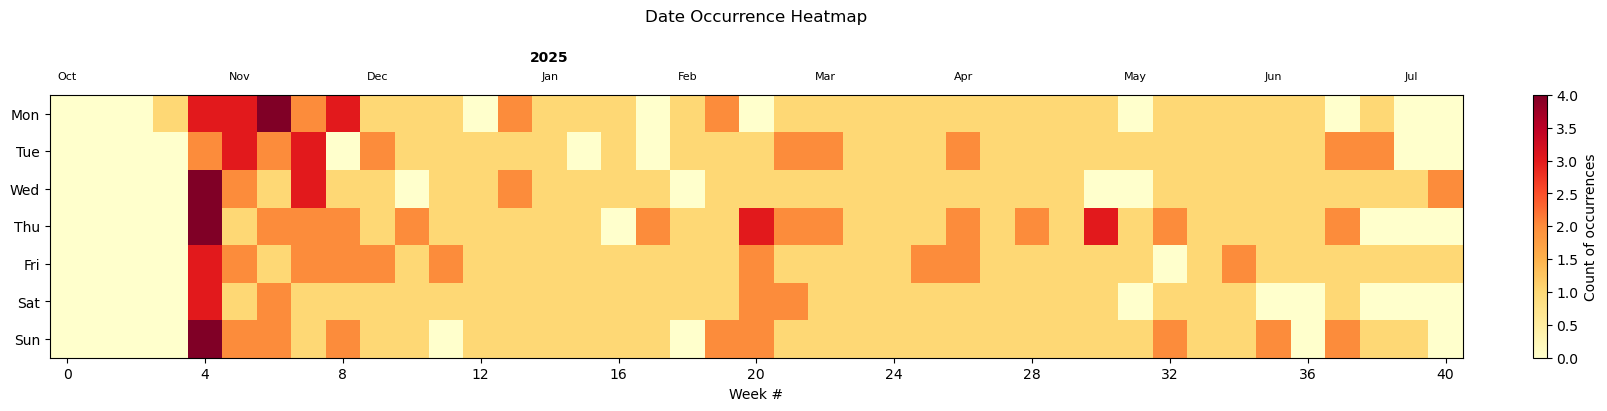

In [57]:
dates= get_type_data(full_df, "diaper").query("customComment=='dirty'")['enteredDate'].dt.date
ax= make_year_heatmap(dates)
plt.sca(ax)
plt.savefig("figures/diapers_map.png")

In [58]:
np.unique(full_df.type)

array(['bathing', 'bottle', 'custom_achieve', 'diaper', 'head_circ',
       'height', 'lactation', 'lure', 'pumping', 'sleep', 'stroll',
       'taking_med', 'temperature', 'vaccination', 'weight'], dtype=object)

In [59]:
all_meals = np.unique(full_df[full_df['type']==('lure')]['customComment'])

In [60]:
from nltk.util import ngrams
import re
from collections import Counter

tokens = []
for meal in all_meals:
    cleaned = re.sub(r'[/,]', ' ', meal.lower())
    cleaned = re.sub(r'\s+', ' ', cleaned.strip())
    words = cleaned.split()
    tokens.extend(words)

# Create bigrams (two-word combos)
bigrams = list(ngrams(tokens, 2))
bigram_counts = Counter(bigrams)

# Filter frequent ones (e.g., that appear at least 3 times)
multi_word_foods = [
    ' '.join(bigram) for bigram, count in bigram_counts.items() if count >= 3
]

# Preview
print(sorted(multi_word_foods))

['acorn squash', 'apple banana', 'apple carrot', 'apple oat', 'apple oats', 'apple pea', 'apple pear', 'apple zucchini', 'avocado apple', 'avocado chicken', 'avocado corn', 'avocado egg', 'banana apple', 'banana oat', 'banana oats', 'carrot apple', 'carrot broccoli', 'carrot chicken', 'carrot zucchini', 'chicken carrot', 'chicken green', 'chicken soup', 'chicken sweet', 'corn husk', 'corn oat', 'corn pea', 'corn peas', 'egg yolk', 'fruit mash', 'green bean', 'green beans', 'mango apple', 'mixed veggies', 'oat apple', 'oat banana', 'oat chicken', 'oat corn', 'oat mango', 'oat pear', 'oat turkey', 'oat water', 'oat zucchini', 'oats banana', 'oats chicken', 'oats water', 'pear oat', 'pear zucchini', 'potato apple', 'potato chicken', 'potato oats', 'potato sweet', 'potato turkey', 'potato zucchini', 'red pepper', 'soup corn', 'squash oat', 'sweet potato', 'toast avocado', 'turkey mixed', 'turkey sweet', 'veal corn', 'veal soup', 'veggies oats', 'water apple', 'water banana', 'yolk avocado'

In [61]:
normalized = []
for meal in all_meals:
    cleaned = re.sub(r'[/,]', ' ', meal)  # replace slashes and commas with space
    cleaned = re.sub(r'\s+', ' ', cleaned.strip())  # remove extra whitespace
    normalized.append(cleaned.lower())

multi_word_foods = ['acorn squash', 'chicken soup', 'corn husk', 'butternut squash'
                    'egg yolk', 'fruit mash', 'green bean', 'green beans',
                    'mixed veggies', 'red pepper', 'sweet potato', 'veal soup']

for i, meal in enumerate(normalized):
    for phrase in multi_word_foods:
        meal = meal.replace(phrase, phrase.replace(' ', '_'))
    normalized[i] = meal

tokens = []
for meal in normalized:
    tokens.extend(meal.split())

tokens = [token.replace('_', ' ') for token in tokens]
counts = Counter(tokens)
unique_foods = sorted(counts.keys())

for food in unique_foods:
    print(food)


365
acorn squash
acorns
apple
asparagus
avocado
bagel
banana
berry
blueberry
broccoli
butternut
carrot
carrots
cauliflower
chicken
chicken soup
cinnamon
core
corn
corn husk
cucumber
dinner
drumstick
egg
finger
food
fruit
fruit mash
gerber
green
green bean
green beans
half
lentil
lentils
lunch
mango
mash
mashed
melts
milk
mixed
mixed veggies
multigrain
oat
oatmeal
oats
omelette
on
organic
pancake
papaya
parsnips
pasta
pb
pea
pear
pears
peas
pepper
potato
prune
prunes
puff
puffs
puree
red pepper
red peppers
rigatoni
roast
squash
stars
stuck
sweet potato
teether
toast
turkey
veal
veal soup
vegetables
veggie
veggies
w
wafer
water
wet
white
whole
yellow
yolk
zucchini
